## Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model

from tensorflow.keras.layers import Input, Masking, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, Lambda, Bidirectional

from keras import backend as K

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



## 사용 X

In [4]:
def create_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            data = pd.read_csv(base_path + csv_path)
            
            features = data.loc[:, data.columns != 'class']

            X.append(features.to_numpy())
            y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [128]:
# 데이터 좌우 대칭 -> x 값만 변화, y값 변화 없음
def revert_datasets(df):
    revert_data = df.copy()
    
    for feature in df.columns:
        if feature[-2:] == '_x':
            revert_data[feature] = 1 - df[feature]
    return revert_data

## 6 Classes Dataset

In [5]:
# 'backhand': 0, 'forehand': 1, 'volley': 2, 'service/smash': 3

sequence_length = 60

def create_dataset_6cls():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # volley를 하나로 묶음
            if folder == 'backhand':
                # 'backhand_volley'
                if int(csv_path[9:-4]) >= 191 and int(csv_path[9:-4]) <= 247:
                    df.loc[df['class'] == 0, 'class'] = 2
            
            if folder == 'forehand':
                # 'forehand_volley'
                if int(csv_path[9:-4]) >= 414 and int(csv_path[9:-4]) <= 470:
                    df.loc[df['class'] == 1, 'class'] = 2
            
            # service와 smash를 하나로 묶음
            if folder == 'service' or folder == 'smash':
                # service
                if int(csv_path[9:-4]) >= 471 and int(csv_path[9:-4]) <= 650:
                    df.loc[df['class'] == 1, 'class'] = 3
                
                # smash
                if int(csv_path[9:-4]) >= 651 and int(csv_path[9:-4]) <= 704:
                    df.loc[df['class'] == 1, 'class'] = 3


            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

IndentationError: expected an indented block after 'if' statement on line 28 (2453213477.py, line 32)

In [6]:
X, y = create_dataset_6cls()

In [7]:
print(X.shape)
print(y.shape)

(10419, 60, 26)
(10419,)


In [8]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 6
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(7293, 60, 26)
(7293, 6)
(3126, 60, 26)
(3126, 6)


## 4 Classes dataset

In [87]:
sequence_length = 17

def create_revert_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                # 데이터 변환
                # revert_data = revert_datasets(df)

                # X.append(revert_data.values[1:])
                # y.append(revert_data['class'].values[0])
                
                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
    

                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [88]:
X, y = create_revert_dataset()

In [89]:
print(X.shape)
print(y.shape)

(682, 50, 26)
(682,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [79]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True)

In [80]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

IndexError: index 4 is out of bounds for axis 1 with size 4

## New  - train, valid, test를 직접 분리해서 만든 dataset

In [4]:
# 각 csv 파일 번호에 matching되는 motion
# 0 - 71: backhand2hands -> backhand
# 72 - 124: backhand
# 125 - 190: backhand_slice -> backhand
# 191 - 247: backhand_volley -> volley
# 248 - 306: forehand_flat -> forehand
# 307 - 355: forehand_openstands -> forehand
# 356 - 413: forehand_slice -> forehand
# 414 - 470: forehand_volley -> volley
# 471 - 539: flat_service -> service/smash
# 540 - 600: kick_service -> service/smash
# 601 - 650: slice_service -> service/smash
# 651 - 704: smash -> service/smash

In [5]:
# backhand: 191개
# forehand: 166개
# volley: 114개
# service/smash: 234개
# 총 705개

In [6]:
# train:valid:test
# 7 : 2 : 1
# backhand: 134 : 38 : 19
# forehand: 117 : 34 : 17
# volley: 80 : 23 : 11
# service/smash: 164 : 47 : 23

# 0 - 71: 50, 15, 7 (72개) -> backhand
# 72 - 124: 37, 11, 5 (53개) -> backhand
# 125 - 190: 46, 14, 6 (66개) -> backhand
# 191 - 247: 40, 11, 6 (57개)-> volley
# 248 - 306: 41, 12, 6 (59개) -> forehand
# 307 - 355: 34, 10, 5 (49개) -> forehand
# 356 - 413: 40, 12, 6 (58개) -> forehand
# 414 - 470: 40, 11, 6 (57개) -> volley
# 471 - 539: 48, 14, 7 (69개) -> service/smash
# 540 - 600: 43, 12, 6 (61개) -> service/smash
# 601 - 650: 35, 10, 5 (50개)-> service/smash
# 651 - 704: 38, 11, 5 (54개) -> service/smash

In [4]:
def average_dataframe(df):
    for i in range(0, len(df) -1, 2):
        avg_row = (df.iloc[i, :] + df.iloc[i + 1, :]) / 2
        if i == 0:
            new_df = avg_row.to_frame().T
        else:
            new_df = pd.concat([new_df, avg_row.to_frame().T], ignore_index=True)

    # df가 홀수일때는 평균X
    if len(df) % 2 == 1:
        new_df = pd.concat([new_df, df.iloc[-1, :].to_frame().T], ignore_index=True)
        
    return new_df

In [12]:
def create_datasets(sequence_length):
    X_train = []
    y_train = []
    X_valid = []
    y_valid = []
    X_test = []
    y_test = []

    folders = ['train', 'valid', 'test']
    motions = ['backhand', 'forehand', 'servicesmash', 'volley']
    for folder in folders:
        for motion in motions:
            base_path = f'../keypoints/{folder}/{folder}_{motion}/'
            for csv_path in os.listdir(base_path):
                df = pd.read_csv(base_path + csv_path)
                df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거
                df = average_dataframe(df)

                if motion == 'backhand':
                    df['class'] = 0

                elif motion == 'forehand':
                    df['class'] = 1

                elif motion == 'servicesmash':
                    df['class'] = 2
                    
                elif motion == 'volley':
                    df['class'] = 3

                # num = 17
                # if len(df) >= num * 3:
                #     df = df[num : num * 3].reset_index(drop=True) # 17 ~ 50

                # Sequence Dataset으로 변경
                num_rows = df.shape[0]
                num_batches = num_rows - sequence_length + 1

                for i in range(num_batches):
                    data = df[i : i+sequence_length]
                    features = data.loc[:, data.columns != 'class']
                    
                    if folder == 'train':
                        X_train.append(features.to_numpy())
                        y_train.append(data["class"].iloc[0])

                    elif folder == 'valid' or folder == 'test':
                        X_valid.append(features.to_numpy())
                        y_valid.append(data["class"].iloc[0]) 

                    # elif folder == 'test':
                    #     X_test.append(features.to_numpy())
                    #     y_test.append(data["class"].iloc[0])
                
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    # X_test = np.array(X_test)
    # y_test = np.array(y_test)
    
    return X_train, y_train, X_valid, y_valid

In [6]:
X_train, y_train, X_valid, y_valid = create_datasets(25)

      nose_x    nose_y  left_shoulder_x  left_shoulder_y  right_shoulder_x  \
0   0.443064  0.242085         0.508383         0.310275          0.430555   
1   0.428425  0.248816         0.495081         0.316313          0.426169   
2   0.411802  0.262216         0.479276         0.320557          0.425376   
3   0.394409  0.280029         0.458614         0.326617          0.426432   
4   0.385205  0.293095         0.445690         0.332299          0.428865   
5   0.375381  0.302507         0.433960         0.338385          0.434096   
6   0.365936  0.314099         0.421381         0.347350          0.444297   
7   0.361159  0.326884         0.412011         0.356051          0.451059   
8   0.358670  0.337244         0.409063         0.361410          0.449410   
9   0.357057  0.345676         0.406553         0.366723          0.446547   
10  0.353178  0.349633         0.408080         0.373343          0.435894   
11  0.351686  0.349488         0.411546         0.376117        

KeyboardInterrupt: 

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(885, 25, 26)
(885,)
(184, 25, 26)
(184,)


In [10]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)
y_test = le.fit_transform(y_test)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7415, 60, 26)
(7415, 4)
(2249, 60, 26)
(2249, 4)
(755, 60, 26)
(755, 4)


## New - train, valid, test를 나중에 분리하는 코드

In [4]:
def create_datasets(sequence_length):
    X = []
    y = []

    motions = ['backhand', 'forehand', 'servicesmash', 'volley']
    for motion in motions:
        base_path = f'../keypoints/datasets/{motion}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거
            
            if motion == 'backhand':
                df['class'] = 0

            elif motion == 'forehand':
                df['class'] = 1

            elif motion == 'servicesmash':
                df['class'] = 2
                
            elif motion == 'volley':
                df['class'] = 3

            # Sequence Dataset으로 변경
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']

                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [5]:
sequence_length = 30
X, y = create_datasets(sequence_length)
print(X.shape)
print(y.shape)

(18615, 47, 26)
(18615,)


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(14892, 47, 26)
(14892, 4)
(3723, 47, 26)
(3723, 4)


## GRU

In [39]:
# Model 정의
model = Sequential([
    Input(shape=(sequence_length, 26)),
    Masking(mask_value=0.0),
    GRU(32, dropout=0.1),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [20]:
# Model 정의
model = Sequential([
    GRU(64, dropout=0.1, input_shape=(sequence_length, 26)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_6 (Masking)         (None, 50, 26)            0         
                                                                 
 gru_10 (GRU)                (None, 32)                5760      
                                                                 
 batch_normalization_10 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 4)                 132       
                                                      

In [41]:
checkpoint = ModelCheckpoint('../models/model/model12.h5', verbose=0, save_best_only=True, period=1)
# period: 1번의 epoch일 때마다 valid loss가 가장 낮은 모델을 저장 -> checkpoint 역할
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 32
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

Epoch 1/200
415/415 [==============================] - 7s 11ms/step - loss: 1.1635 - acc: 0.4829 - val_loss: 1.0533 - val_acc: 0.5581
Epoch 2/200
415/415 [==============================] - 3s 8ms/step - loss: 0.8394 - acc: 0.6474 - val_loss: 1.5998 - val_acc: 0.3964
Epoch 3/200
415/415 [==============================] - 3s 8ms/step - loss: 0.7567 - acc: 0.6886 - val_loss: 0.6872 - val_acc: 0.6907
Epoch 4/200
415/415 [==============================] - 3s 8ms/step - loss: 0.6955 - acc: 0.7147 - val_loss: 0.5276 - val_acc: 0.7952
Epoch 5/200
415/415 [==============================] - 3s 8ms/step - loss: 0.6400 - acc: 0.7411 - val_loss: 0.9342 - val_acc: 0.6039
Epoch 6/200
415/415 [==============================] - 3s 8ms/step - loss: 0.6097 - acc: 0.7508 - val_loss: 0.9646 - val_acc: 0.6645
Epoch 7/200
415/415 [==============================] - 3s 8ms/step - loss: 0.6005 - acc: 0.7563 - val_loss: 0.5275 - val_acc: 0.7777
Epoch 8/200
415/415 [==============================] - 3s 8ms/step -

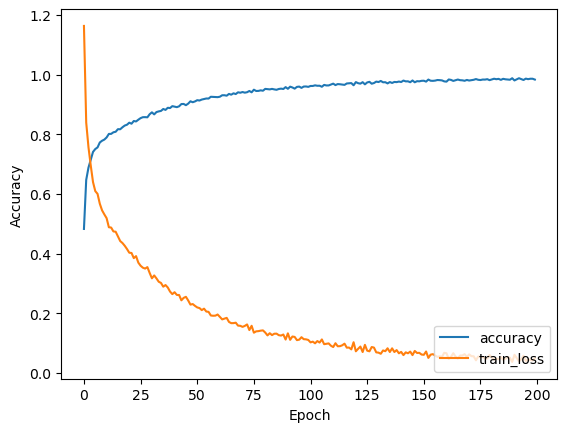

In [42]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

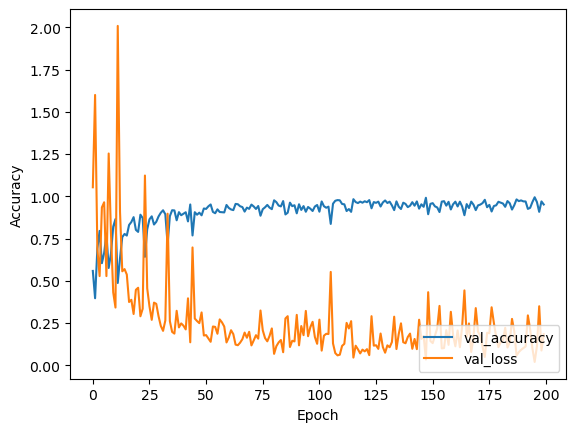

In [43]:
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [44]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('../models/model/model12.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

104/104 [==============================] - 1s 5ms/step - loss: 0.1839 - acc: 0.9515
Accuracy on validation dataset = 0.9515060186386108
104/104 [==============================] - 0s 3ms/step - loss: 0.0195 - acc: 0.9943
Accuracy on validation dataset = 0.9942771196365356


In [38]:
# 모델 저장
model.save('../models/gru/gru32_seq50.h5')

## LSTM

In [54]:
units = 128
model = Sequential([
    Dropout(0.1, input_shape=(sequence_length, 26)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5), merge_mode='concat'),
    TimeDistributed(Dropout(0.1)),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(num_classes, activation='softmax')),
    Lambda(function=lambda x: K.mean(x, axis=1))
])

In [14]:
model = Sequential([
    Input(shape=(sequence_length, 26)),
    Masking(mask_value=0.0),
    LSTM(45, dropout=0.1, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    # LSTM(64, dropout=0.1, return_sequences=False),
    # BatchNormalization(),
    # Dropout(0.3),
    Dense(45, activation='relu'), # , kernel_regularizer=l2(0.001)
    Dense(num_classes, activation='softmax')
])

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 60, 26)            0         
                                                                 
 lstm (LSTM)                 (None, 45)                12960     
                                                                 
 batch_normalization_1 (Batc  (None, 45)               180       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 45)                0         
                                                                 
 dense_2 (Dense)             (None, 45)                2070      
                                                                 
 dense_3 (Dense)             (None, 4)                 184       
                                                      

In [16]:
checkpoint = ModelCheckpoint('../models/model/model12.h5', verbose=1, save_best_only=True, period=1)
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 16

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/300
459/464 [============================>.] - ETA: 0s - loss: 0.9987 - accuracy: 0.5681
Epoch 1: val_loss improved from inf to 1.66681, saving model to ../models/model\model12.h5
464/464 [==============================] - 9s 12ms/step - loss: 0.9947 - accuracy: 0.5703 - val_loss: 1.6668 - val_accuracy: 0.5834
Epoch 2/300
459/464 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.7342
Epoch 2: val_loss improved from 1.66681 to 0.50360, saving model to ../models/model\model12.h5
464/464 [==============================] - 4s 10ms/step - loss: 0.6740 - accuracy: 0.7336 - val_loss: 0.5036 - val_accuracy: 0.7817
Epoch 3/300
459/464 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7785
Epoch 3: val_loss did not improve from 0.50360
464/464 [==============================] - 4s 10ms/step - loss: 0.5669 - accuracy: 0.7788 - val_loss: 0.5065 - val_accuracy: 0.7946
Epoch 4/300
461/464 [============================>.] - ETA: 0s - loss: 0.5283 - 

KeyboardInterrupt: 

In [30]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('../models/lstm/model12.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

98/98 [==============================] - 1s 5ms/step - loss: 0.0089 - accuracy: 0.9968
Accuracy on validation dataset = 0.9968010187149048
98/98 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.9968
Accuracy on validation dataset = 0.9968010187149048


In [55]:
model.save('../models/model_2lstm_seq50.h5')

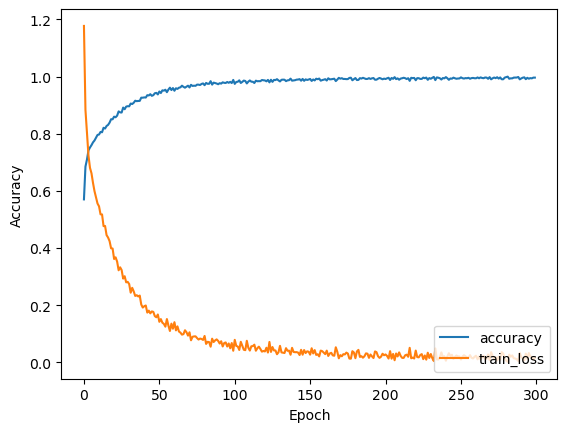

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

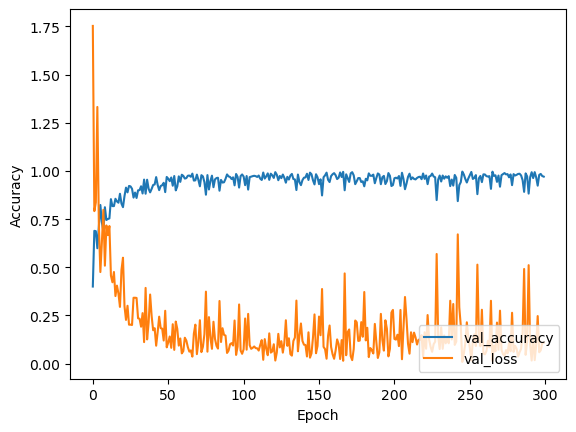

In [26]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
model.save('models/lstm/1lstm64.h5')

## 전체

seq: 30, unit: 40
start
Epoch 1/200
761/761 [==============================] - 18s 11ms/step - loss: 1.1368 - acc: 0.5012 - val_loss: 1.3192 - val_acc: 0.3743
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.9121 - acc: 0.6147 - val_loss: 1.8985 - val_acc: 0.3667
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8516 - acc: 0.6438 - val_loss: 0.9223 - val_acc: 0.6027
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8130 - acc: 0.6600 - val_loss: 0.8269 - val_acc: 0.6310
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7636 - acc: 0.6838 - val_loss: 0.7381 - val_acc: 0.6560
Epoch 6/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7300 - acc: 0.6999 - val_loss: 0.7010 - val_acc: 0.7079
Epoch 7/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7043 - acc: 0.7148 - val_loss: 0.9972 - val_acc: 0.5713
Epoch 8/200
761/761 [======================

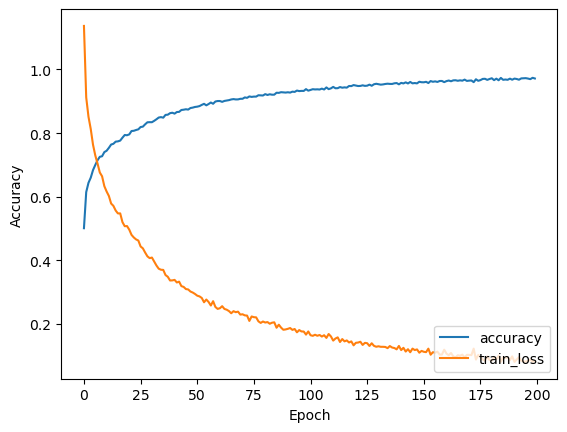

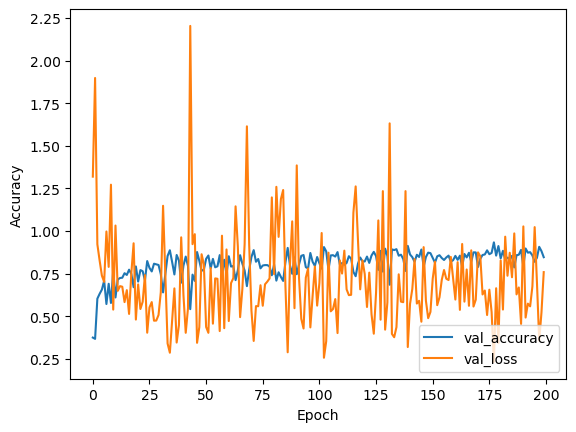

191/191 [==============================] - 1s 3ms/step - loss: 0.7586 - acc: 0.8462
Accuracy on validation dataset = 0.846242368221283
191/191 [==============================] - 1s 3ms/step - loss: 0.2313 - acc: 0.9334
Accuracy on validation dataset = 0.9333991408348083
seq: 30, unit: 45
start
Epoch 1/200
761/761 [==============================] - 11s 9ms/step - loss: 1.1143 - acc: 0.5121 - val_loss: 1.0054 - val_acc: 0.5410
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8875 - acc: 0.6230 - val_loss: 0.8821 - val_acc: 0.6147
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8192 - acc: 0.6613 - val_loss: 1.6034 - val_acc: 0.4535
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7787 - acc: 0.6753 - val_loss: 1.0337 - val_acc: 0.5637
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7415 - acc: 0.6935 - val_loss: 0.6902 - val_acc: 0.6963
Epoch 6/200
761/761 [==================

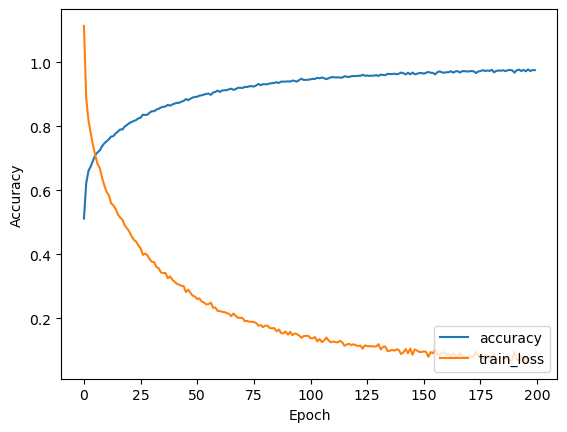

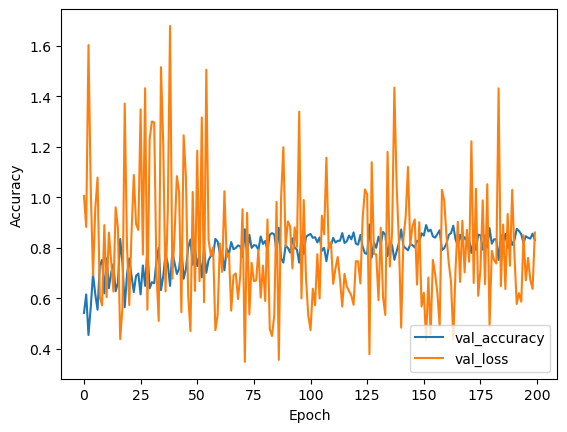

191/191 [==============================] - 1s 3ms/step - loss: 0.8599 - acc: 0.8303
Accuracy on validation dataset = 0.8302910923957825
191/191 [==============================] - 1s 3ms/step - loss: 0.3470 - acc: 0.8729
Accuracy on validation dataset = 0.8728827238082886
seq: 30, unit: 50
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.1103 - acc: 0.5115 - val_loss: 1.2441 - val_acc: 0.4537
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8834 - acc: 0.6254 - val_loss: 0.7823 - val_acc: 0.6514
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8143 - acc: 0.6606 - val_loss: 1.8684 - val_acc: 0.3508
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7667 - acc: 0.6820 - val_loss: 0.9029 - val_acc: 0.6172
Epoch 5/200
761/761 [==============================] - 6s 9ms/step - loss: 0.7281 - acc: 0.6977 - val_loss: 0.6920 - val_acc: 0.7106
Epoch 6/200
761/761 [================

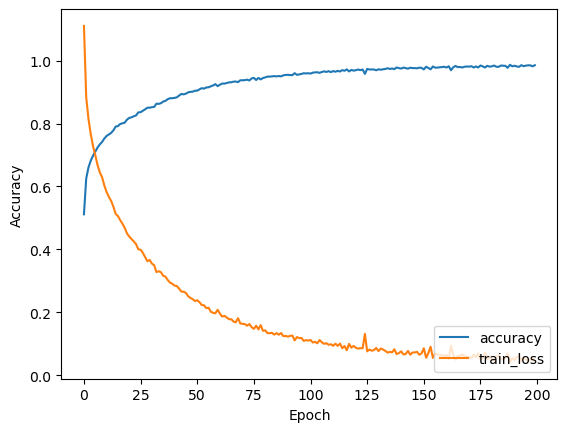

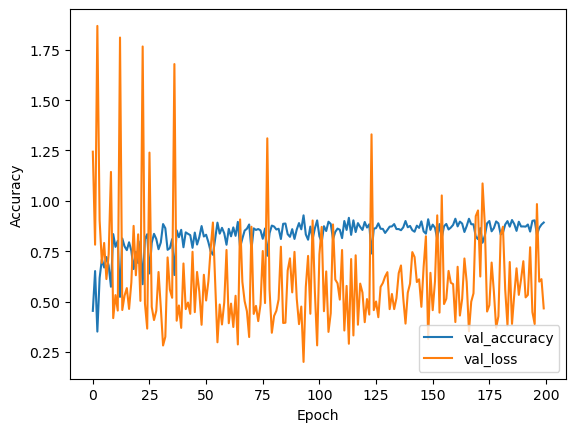

191/191 [==============================] - 1s 3ms/step - loss: 0.4660 - acc: 0.8923
Accuracy on validation dataset = 0.8922874331474304
191/191 [==============================] - 1s 3ms/step - loss: 0.2002 - acc: 0.9280
Accuracy on validation dataset = 0.9279723763465881
seq: 30, unit: 55
start
Epoch 1/200
761/761 [==============================] - 12s 11ms/step - loss: 1.0579 - acc: 0.5412 - val_loss: 1.7044 - val_acc: 0.3365
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8436 - acc: 0.6491 - val_loss: 0.9386 - val_acc: 0.6200
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7882 - acc: 0.6714 - val_loss: 1.0210 - val_acc: 0.5685
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7473 - acc: 0.6905 - val_loss: 0.7656 - val_acc: 0.6517
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7083 - acc: 0.7071 - val_loss: 0.7256 - val_acc: 0.6884
Epoch 6/200
761/761 [================

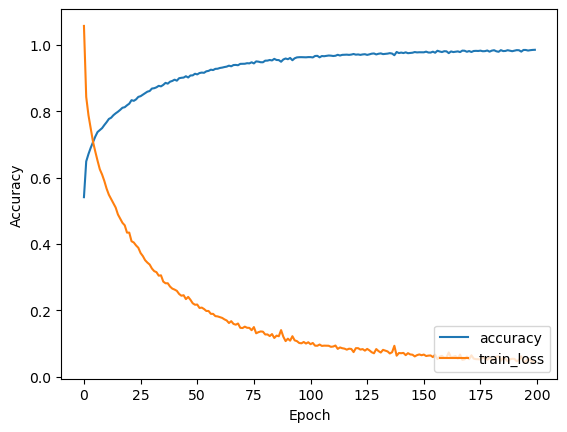

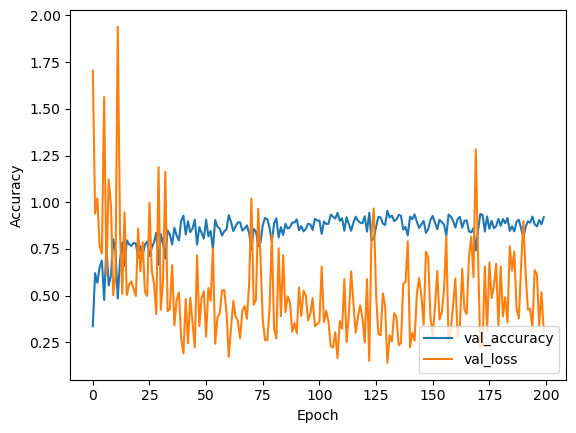

191/191 [==============================] - 1s 3ms/step - loss: 0.3076 - acc: 0.9196
Accuracy on validation dataset = 0.9195855855941772
191/191 [==============================] - 1s 3ms/step - loss: 0.1396 - acc: 0.9540
Accuracy on validation dataset = 0.9539549350738525
seq: 30, unit: 60
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0787 - acc: 0.5354 - val_loss: 1.5893 - val_acc: 0.3886
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8518 - acc: 0.6413 - val_loss: 1.3325 - val_acc: 0.5085
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7874 - acc: 0.6725 - val_loss: 0.9936 - val_acc: 0.5705
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7507 - acc: 0.6920 - val_loss: 1.1132 - val_acc: 0.5372
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7043 - acc: 0.7078 - val_loss: 1.3337 - val_acc: 0.5252
Epoch 6/200
761/761 [================

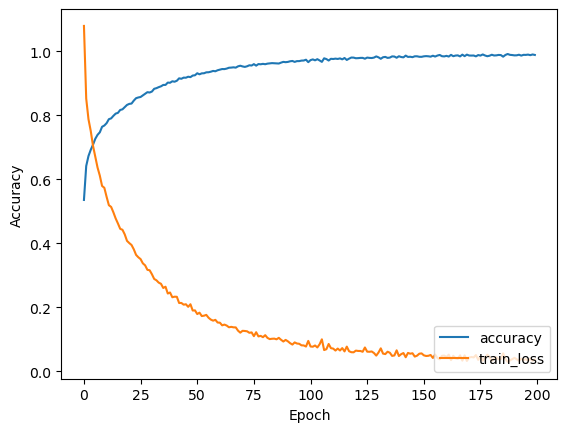

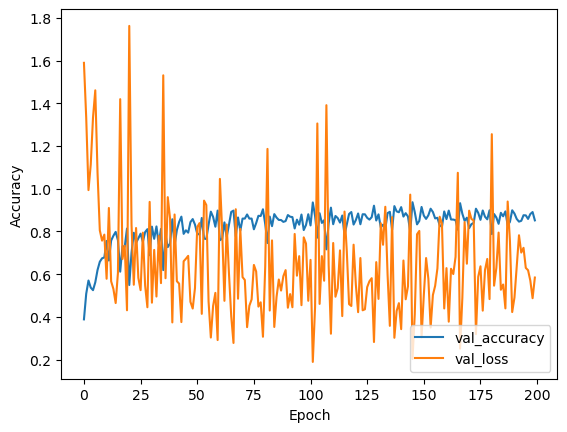

191/191 [==============================] - 1s 3ms/step - loss: 0.5844 - acc: 0.8520
Accuracy on validation dataset = 0.8519980311393738
191/191 [==============================] - 1s 3ms/step - loss: 0.1894 - acc: 0.9359
Accuracy on validation dataset = 0.9358658194541931
seq: 30, unit: 65
start
Epoch 1/200
761/761 [==============================] - 12s 11ms/step - loss: 1.0614 - acc: 0.5383 - val_loss: 2.8468 - val_acc: 0.3733
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8403 - acc: 0.6481 - val_loss: 1.1772 - val_acc: 0.5137
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7736 - acc: 0.6794 - val_loss: 0.7158 - val_acc: 0.6805
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7303 - acc: 0.7008 - val_loss: 0.6286 - val_acc: 0.7209
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.6968 - acc: 0.7112 - val_loss: 1.2177 - val_acc: 0.5830
Epoch 6/200
761/761 [================

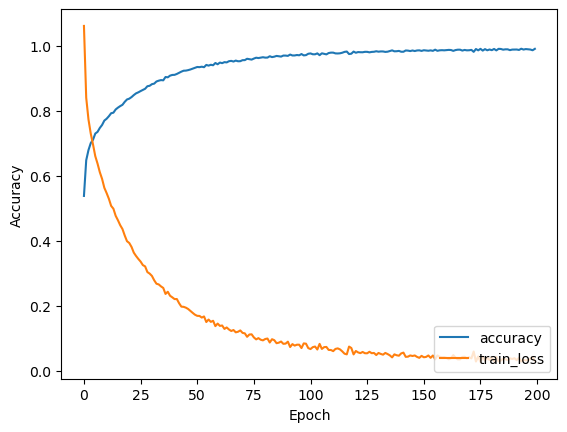

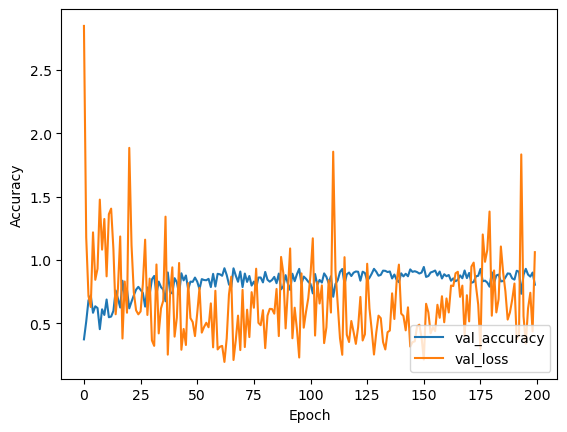

191/191 [==============================] - 1s 3ms/step - loss: 1.0613 - acc: 0.8048
Accuracy on validation dataset = 0.8048018217086792
191/191 [==============================] - 1s 3ms/step - loss: 0.1952 - acc: 0.9346
Accuracy on validation dataset = 0.9345502257347107
seq: 30, unit: 70
start
Epoch 1/200
761/761 [==============================] - 12s 11ms/step - loss: 1.0394 - acc: 0.5522 - val_loss: 1.8627 - val_acc: 0.4690
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8378 - acc: 0.6487 - val_loss: 1.7824 - val_acc: 0.4383
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7721 - acc: 0.6813 - val_loss: 1.6299 - val_acc: 0.4873
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7204 - acc: 0.7005 - val_loss: 0.8003 - val_acc: 0.6553
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.6906 - acc: 0.7132 - val_loss: 0.9085 - val_acc: 0.5867
Epoch 6/200
761/761 [================

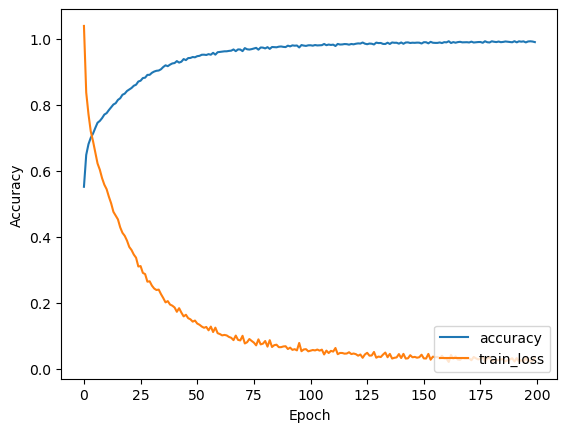

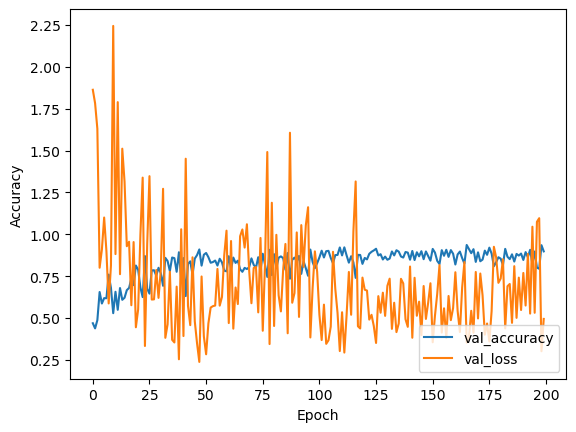

191/191 [==============================] - 1s 3ms/step - loss: 0.4948 - acc: 0.8980
Accuracy on validation dataset = 0.8980430960655212
191/191 [==============================] - 1s 3ms/step - loss: 0.2380 - acc: 0.9096
Accuracy on validation dataset = 0.9095543622970581
seq: 30, unit: 75
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0212 - acc: 0.5576 - val_loss: 1.2215 - val_acc: 0.5091
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8249 - acc: 0.6562 - val_loss: 2.2422 - val_acc: 0.4221
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7655 - acc: 0.6801 - val_loss: 1.3044 - val_acc: 0.5603
Epoch 4/200
761/761 [==============================] - 6s 9ms/step - loss: 0.7140 - acc: 0.7044 - val_loss: 1.5803 - val_acc: 0.5113
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6783 - acc: 0.7221 - val_loss: 1.0096 - val_acc: 0.5948
Epoch 6/200
761/761 [================

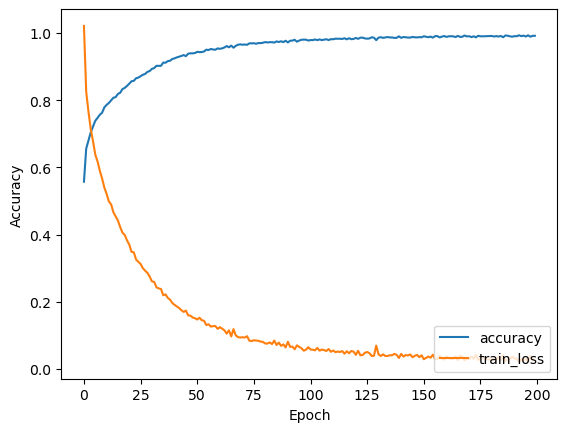

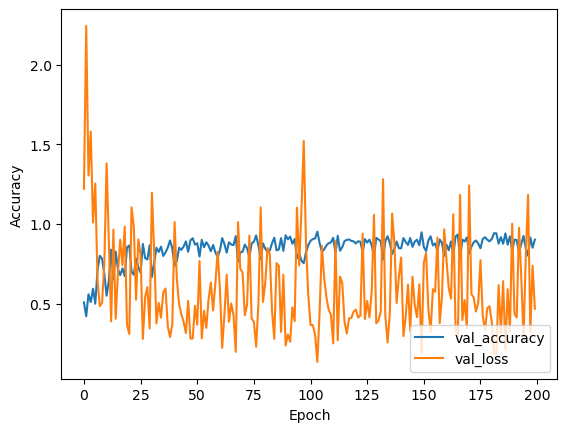

191/191 [==============================] - 1s 3ms/step - loss: 0.4695 - acc: 0.9025
Accuracy on validation dataset = 0.9024831652641296
191/191 [==============================] - 1s 3ms/step - loss: 0.1360 - acc: 0.9528
Accuracy on validation dataset = 0.9528037905693054
seq: 30, unit: 80
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0300 - acc: 0.5564 - val_loss: 1.6935 - val_acc: 0.3879
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8287 - acc: 0.6513 - val_loss: 0.9445 - val_acc: 0.6019
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7659 - acc: 0.6821 - val_loss: 0.8301 - val_acc: 0.6433
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7161 - acc: 0.7054 - val_loss: 0.7849 - val_acc: 0.6632
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6717 - acc: 0.7243 - val_loss: 1.2461 - val_acc: 0.5323
Epoch 6/200
761/761 [================

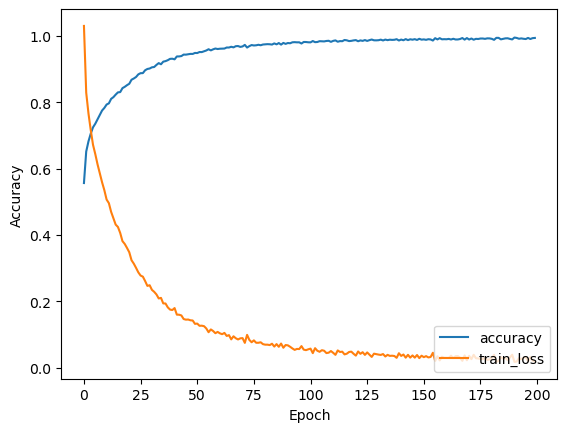

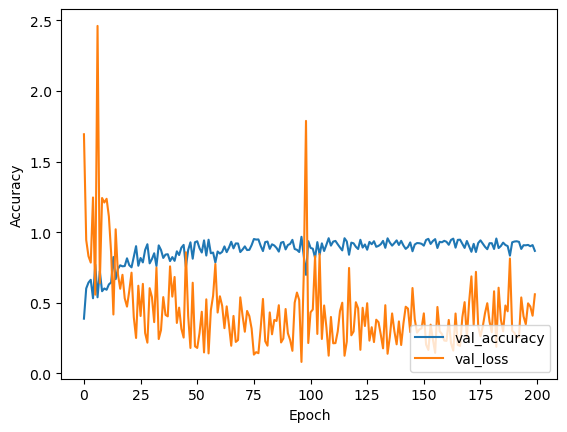

191/191 [==============================] - 1s 3ms/step - loss: 0.5604 - acc: 0.8678
Accuracy on validation dataset = 0.8677849173545837
191/191 [==============================] - 1s 3ms/step - loss: 0.0817 - acc: 0.9674
Accuracy on validation dataset = 0.967439591884613
seq: 30, unit: 85
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0303 - acc: 0.5559 - val_loss: 1.5753 - val_acc: 0.4493
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8170 - acc: 0.6589 - val_loss: 0.6571 - val_acc: 0.7298
Epoch 3/200
761/761 [==============================] - 6s 9ms/step - loss: 0.7605 - acc: 0.6848 - val_loss: 0.5930 - val_acc: 0.7568
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7169 - acc: 0.7038 - val_loss: 1.5739 - val_acc: 0.4534
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6782 - acc: 0.7192 - val_loss: 1.0674 - val_acc: 0.5680
Epoch 6/200
761/761 [=================

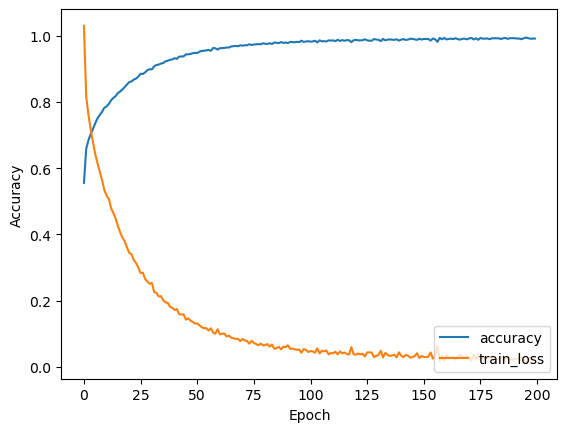

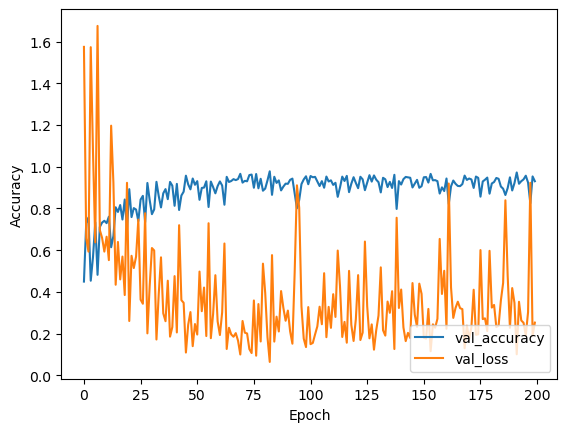

191/191 [==============================] - 1s 3ms/step - loss: 0.2523 - acc: 0.9308
Accuracy on validation dataset = 0.9307679533958435
191/191 [==============================] - 1s 3ms/step - loss: 0.0638 - acc: 0.9785
Accuracy on validation dataset = 0.978457510471344
seq: 30, unit: 90
start
Epoch 1/200
761/761 [==============================] - 12s 11ms/step - loss: 1.0155 - acc: 0.5641 - val_loss: 3.7194 - val_acc: 0.3735
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7960 - acc: 0.6686 - val_loss: 1.5838 - val_acc: 0.3736
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7465 - acc: 0.6899 - val_loss: 0.8546 - val_acc: 0.6506
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7060 - acc: 0.7070 - val_loss: 1.0961 - val_acc: 0.5562
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.6601 - acc: 0.7293 - val_loss: 0.7072 - val_acc: 0.6931
Epoch 6/200
761/761 [=================

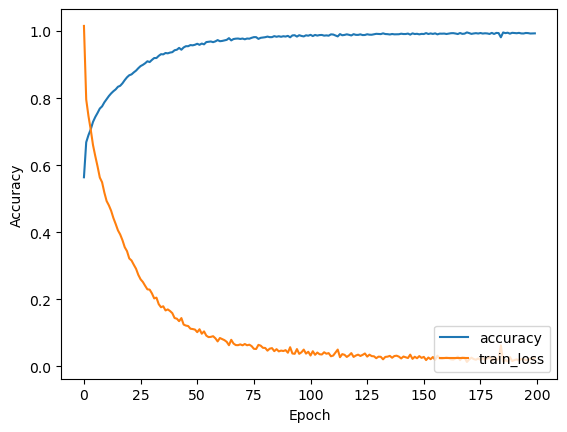

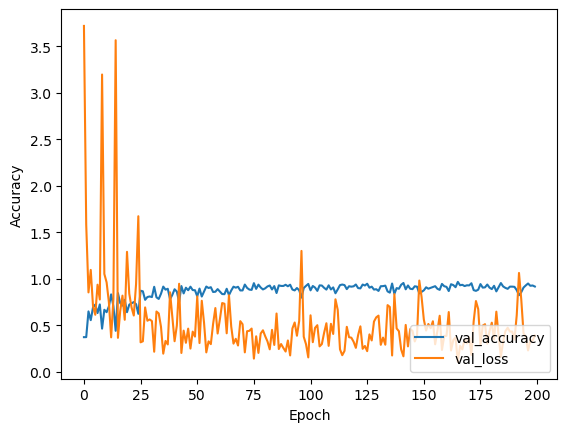

191/191 [==============================] - 1s 3ms/step - loss: 0.3915 - acc: 0.9176
Accuracy on validation dataset = 0.9176122546195984
191/191 [==============================] - 1s 3ms/step - loss: 0.1072 - acc: 0.9676
Accuracy on validation dataset = 0.9676040410995483


In [5]:
sequence_lengths = [30]
units = [i for i in range(40, 95, 5)]
num_classes = 4

for seq in sequence_lengths:
    for unit in units:
        print(f'seq: {seq}, unit: {unit}')
        print('start')
        X, y = create_datasets(seq)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

        # One-hot Encoding
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_valid = le.fit_transform(y_valid)
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_valid = to_categorical(y_valid, num_classes=num_classes)

        model = Sequential([
            Input(shape=(seq, 26)),
            Masking(mask_value=0.0),
            GRU(unit, dropout=0.1),
            BatchNormalization(),
            Dropout(0.5),
            Dense(unit, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        
        checkpoint = ModelCheckpoint(f'../models/model/gru{unit}_seq{seq}.h5', verbose=0, save_best_only=True, period=1)
        # scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

        batch_size = 32
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=200,
            batch_size=batch_size,
            callbacks=[checkpoint]
        )

        # train
        plt.plot(history.history['acc'], label='accuracy')
        plt.plot(history.history['loss'], label = 'train_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        
        # valid
        plt.plot(history.history['val_acc'], label='val_accuracy')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        model.load_weights(f'../models/model/gru{unit}_seq{seq}.h5')

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

seq: 47, unit: 40
start
Epoch 1/200
466/466 [==============================] - 9s 12ms/step - loss: 1.1125 - acc: 0.5079 - val_loss: 0.9295 - val_acc: 0.5627
Epoch 2/200
466/466 [==============================] - 4s 9ms/step - loss: 0.8115 - acc: 0.6644 - val_loss: 1.2446 - val_acc: 0.5275
Epoch 3/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7253 - acc: 0.7076 - val_loss: 0.9908 - val_acc: 0.5890
Epoch 4/200
466/466 [==============================] - 4s 8ms/step - loss: 0.6524 - acc: 0.7376 - val_loss: 1.0368 - val_acc: 0.5928
Epoch 5/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6137 - acc: 0.7463 - val_loss: 0.6293 - val_acc: 0.7104
Epoch 6/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5854 - acc: 0.7605 - val_loss: 0.8606 - val_acc: 0.6433
Epoch 7/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5533 - acc: 0.7725 - val_loss: 0.4129 - val_acc: 0.8235
Epoch 8/200
466/466 [=======================

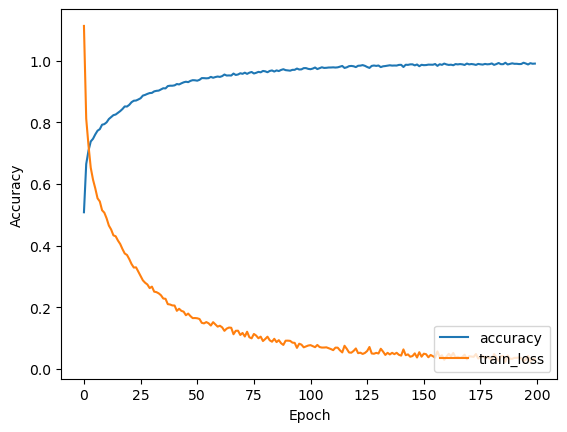

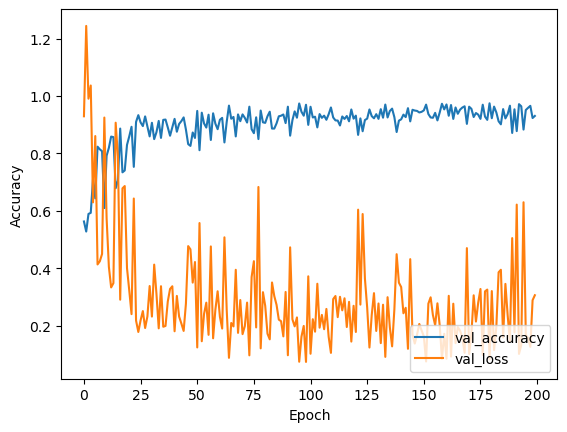

seq: 47, unit: 45
start
Epoch 1/200
466/466 [==============================] - 9s 11ms/step - loss: 1.1474 - acc: 0.5040 - val_loss: 1.5021 - val_acc: 0.4085
Epoch 2/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7955 - acc: 0.6728 - val_loss: 0.8120 - val_acc: 0.6503
Epoch 3/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7066 - acc: 0.7104 - val_loss: 0.5884 - val_acc: 0.7669
Epoch 4/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6329 - acc: 0.7450 - val_loss: 0.7371 - val_acc: 0.6879
Epoch 5/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5975 - acc: 0.7568 - val_loss: 0.6912 - val_acc: 0.7185
Epoch 6/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5741 - acc: 0.7722 - val_loss: 0.8060 - val_acc: 0.6715
Epoch 7/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5402 - acc: 0.7812 - val_loss: 0.7636 - val_acc: 0.6731
Epoch 8/200
466/466 [=======================

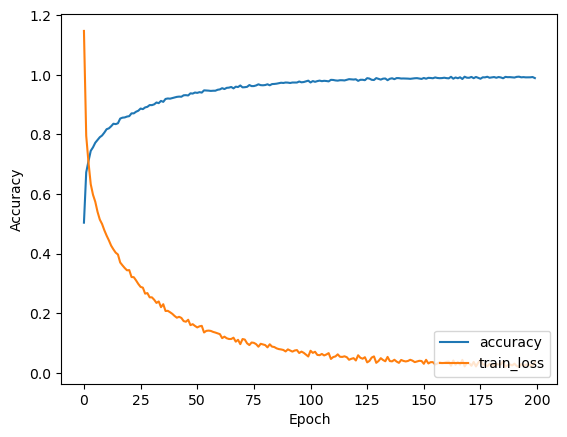

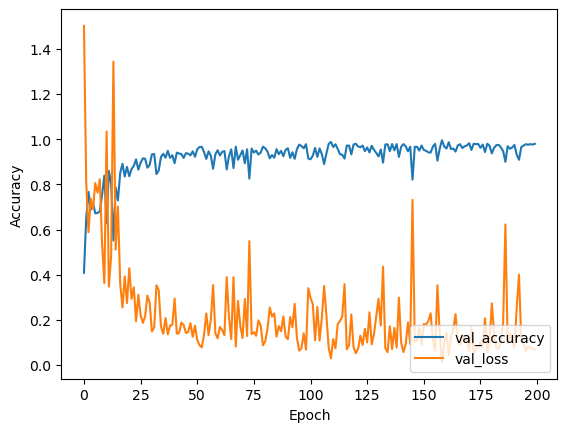

seq: 47, unit: 50
start
Epoch 1/200
466/466 [==============================] - 10s 12ms/step - loss: 1.0481 - acc: 0.5392 - val_loss: 2.2127 - val_acc: 0.3930
Epoch 2/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7463 - acc: 0.6990 - val_loss: 2.3762 - val_acc: 0.4115
Epoch 3/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6569 - acc: 0.7309 - val_loss: 1.2429 - val_acc: 0.4926
Epoch 4/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6030 - acc: 0.7591 - val_loss: 1.0436 - val_acc: 0.6293
Epoch 5/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5740 - acc: 0.7654 - val_loss: 0.4731 - val_acc: 0.7999
Epoch 6/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5433 - acc: 0.7799 - val_loss: 1.0054 - val_acc: 0.6403
Epoch 7/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5067 - acc: 0.7946 - val_loss: 0.3832 - val_acc: 0.8394
Epoch 8/200
466/466 [======================

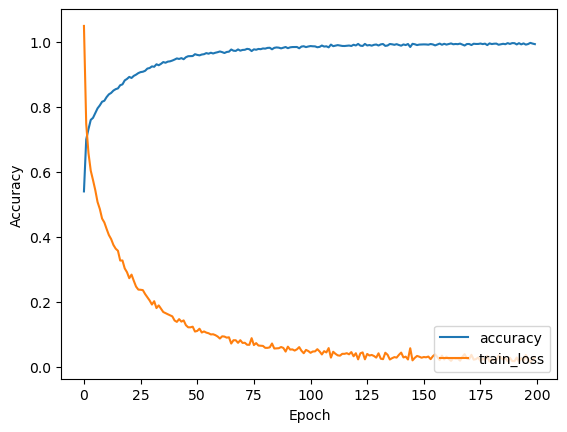

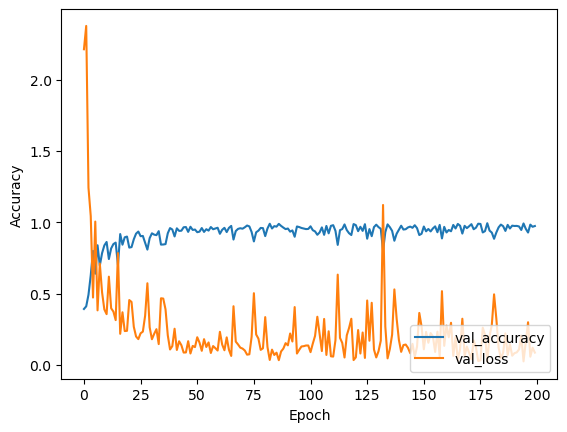

seq: 47, unit: 55
start
Epoch 1/200
466/466 [==============================] - 10s 13ms/step - loss: 1.0787 - acc: 0.5331 - val_loss: 1.0251 - val_acc: 0.5122
Epoch 2/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7746 - acc: 0.6858 - val_loss: 1.6812 - val_acc: 0.3844
Epoch 3/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6708 - acc: 0.7314 - val_loss: 0.8317 - val_acc: 0.6769
Epoch 4/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6110 - acc: 0.7518 - val_loss: 0.5269 - val_acc: 0.7832
Epoch 5/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5724 - acc: 0.7730 - val_loss: 0.6801 - val_acc: 0.7319
Epoch 6/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5410 - acc: 0.7822 - val_loss: 1.0838 - val_acc: 0.6111
Epoch 7/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5042 - acc: 0.7994 - val_loss: 0.5534 - val_acc: 0.7478
Epoch 8/200
466/466 [======================

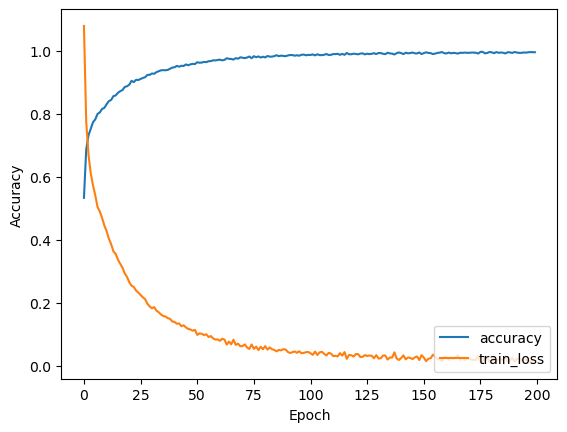

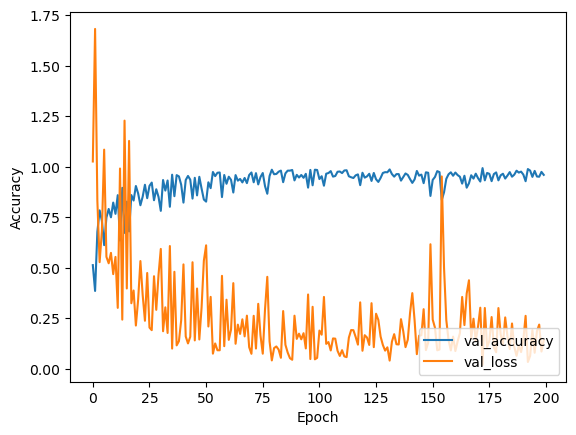

seq: 47, unit: 60
start
Epoch 1/200
466/466 [==============================] - 10s 12ms/step - loss: 1.0565 - acc: 0.5424 - val_loss: 1.0499 - val_acc: 0.4821
Epoch 2/200
466/466 [==============================] - 4s 9ms/step - loss: 0.7330 - acc: 0.7055 - val_loss: 0.9130 - val_acc: 0.6017
Epoch 3/200
466/466 [==============================] - 4s 9ms/step - loss: 0.6486 - acc: 0.7375 - val_loss: 0.4961 - val_acc: 0.7822
Epoch 4/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5937 - acc: 0.7558 - val_loss: 1.5244 - val_acc: 0.5804
Epoch 5/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5573 - acc: 0.7780 - val_loss: 0.8339 - val_acc: 0.6489
Epoch 6/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5349 - acc: 0.7885 - val_loss: 1.0137 - val_acc: 0.6215
Epoch 7/200
466/466 [==============================] - 4s 9ms/step - loss: 0.5006 - acc: 0.7974 - val_loss: 0.5085 - val_acc: 0.7945
Epoch 8/200
466/466 [======================

KeyboardInterrupt: 

In [46]:
sequence_lengths = [47, 50, 53, 55, 60]
units = [i for i in range(40, 95, 5)]
num_classes = 4

for seq in sequence_lengths:
    for unit in units:
        print(f'seq: {seq}, unit: {unit}')
        print('start')
        X, y = create_datasets(seq)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

        # One-hot Encoding
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_valid = le.fit_transform(y_valid)
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_valid = to_categorical(y_valid, num_classes=num_classes)

        model = Sequential([
            Input(shape=(seq, 26)),
            Masking(mask_value=0.0),
            GRU(unit, dropout=0.1),
            BatchNormalization(),
            Dropout(0.5),
            Dense(unit, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        
        checkpoint = ModelCheckpoint(f'../models/model/gru{unit}_seq{seq}.h5', verbose=0, save_best_only=True, period=1)
        # scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

        batch_size = 32
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=200,
            batch_size=batch_size,
            callbacks=[checkpoint]
        )

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        model.load_weights(f'../models/model/gru{unit}_seq{seq}.h5')

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        # train
        plt.plot(history.history['acc'], label='accuracy')
        plt.plot(history.history['loss'], label = 'train_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        
        # valid
        plt.plot(history.history['val_acc'], label='val_accuracy')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

seq: 30, unit: 80
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0090 - acc: 0.5665 - val_loss: 1.8574 - val_acc: 0.3077
Epoch 2/200
761/761 [==============================] - 6s 8ms/step - loss: 0.8087 - acc: 0.6589 - val_loss: 1.0865 - val_acc: 0.5853
Epoch 3/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7543 - acc: 0.6884 - val_loss: 1.0631 - val_acc: 0.5703
Epoch 4/200
761/761 [==============================] - 6s 8ms/step - loss: 0.7123 - acc: 0.7081 - val_loss: 0.7664 - val_acc: 0.6584
Epoch 5/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6739 - acc: 0.7239 - val_loss: 1.1934 - val_acc: 0.5221
Epoch 6/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6427 - acc: 0.7378 - val_loss: 0.6201 - val_acc: 0.7538
Epoch 7/200
761/761 [==============================] - 6s 8ms/step - loss: 0.6138 - acc: 0.7512 - val_loss: 1.3796 - val_acc: 0.5856
Epoch 8/200
761/761 [======================

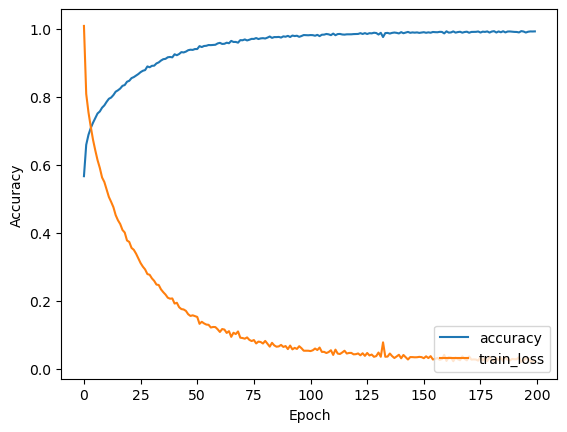

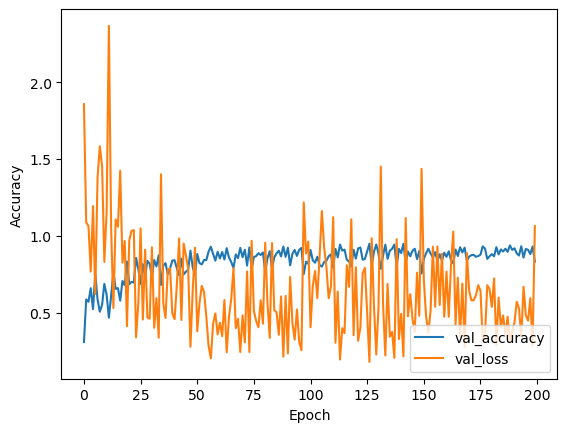

191/191 [==============================] - 1s 3ms/step - loss: 1.0627 - acc: 0.8318
Accuracy on validation dataset = 0.8317710757255554
191/191 [==============================] - 1s 3ms/step - loss: 0.1784 - acc: 0.9485
Accuracy on validation dataset = 0.9485282301902771
seq: 30, unit: 85
start
Epoch 1/200
761/761 [==============================] - 12s 11ms/step - loss: 1.0273 - acc: 0.5549 - val_loss: 1.1153 - val_acc: 0.4575
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8172 - acc: 0.6560 - val_loss: 0.7638 - val_acc: 0.6862
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7595 - acc: 0.6876 - val_loss: 1.1068 - val_acc: 0.5407
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7228 - acc: 0.7035 - val_loss: 0.8542 - val_acc: 0.6446
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.6733 - acc: 0.7256 - val_loss: 1.6771 - val_acc: 0.4458
Epoch 6/200
761/761 [================

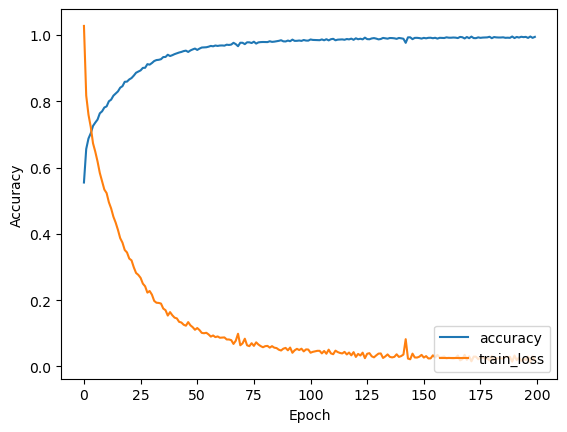

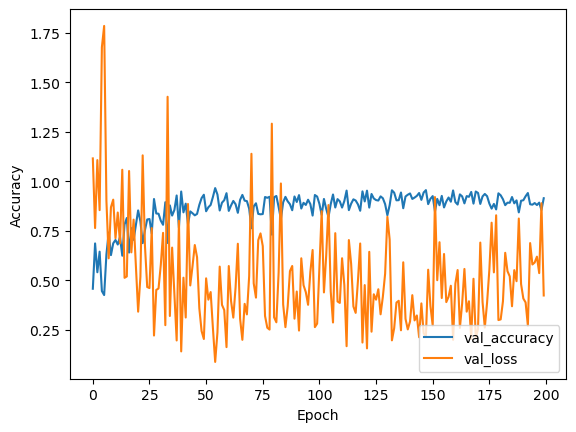

191/191 [==============================] - 1s 3ms/step - loss: 0.4234 - acc: 0.9143
Accuracy on validation dataset = 0.9143233299255371
191/191 [==============================] - 1s 3ms/step - loss: 0.0881 - acc: 0.9655
Accuracy on validation dataset = 0.9654662013053894
seq: 30, unit: 90
start
Epoch 1/200
761/761 [==============================] - 11s 10ms/step - loss: 1.0012 - acc: 0.5668 - val_loss: 1.2155 - val_acc: 0.5224
Epoch 2/200
761/761 [==============================] - 7s 9ms/step - loss: 0.8024 - acc: 0.6647 - val_loss: 1.9320 - val_acc: 0.5397
Epoch 3/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7525 - acc: 0.6917 - val_loss: 0.6995 - val_acc: 0.7027
Epoch 4/200
761/761 [==============================] - 7s 9ms/step - loss: 0.7108 - acc: 0.7058 - val_loss: 1.2986 - val_acc: 0.5687
Epoch 5/200
761/761 [==============================] - 7s 9ms/step - loss: 0.6689 - acc: 0.7262 - val_loss: 0.9801 - val_acc: 0.6211
Epoch 6/200
761/761 [================

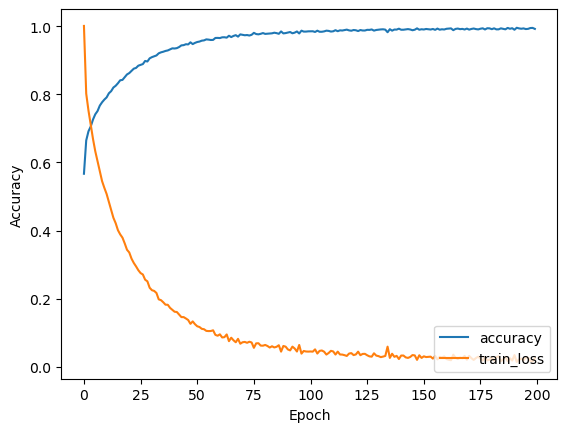

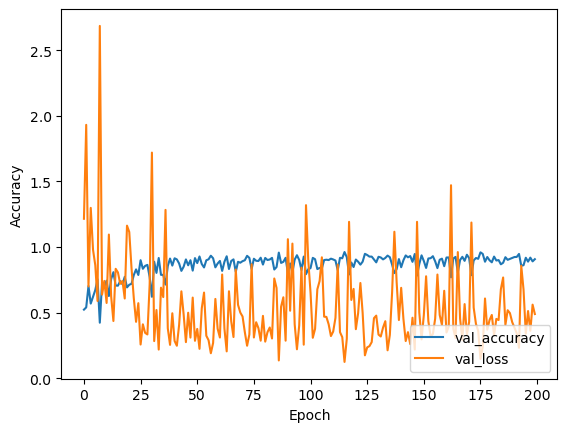

191/191 [==============================] - 1s 3ms/step - loss: 0.4888 - acc: 0.9073
Accuracy on validation dataset = 0.9072520732879639
191/191 [==============================] - 1s 3ms/step - loss: 0.1236 - acc: 0.9618
Accuracy on validation dataset = 0.9618483781814575
seq: 32, unit: 80
start
Epoch 1/200
726/726 [==============================] - 11s 10ms/step - loss: 1.0060 - acc: 0.5648 - val_loss: 2.6225 - val_acc: 0.3074
Epoch 2/200
726/726 [==============================] - 6s 8ms/step - loss: 0.8033 - acc: 0.6610 - val_loss: 0.7960 - val_acc: 0.6725
Epoch 3/200
726/726 [==============================] - 6s 8ms/step - loss: 0.7406 - acc: 0.6963 - val_loss: 0.8992 - val_acc: 0.6106
Epoch 4/200
726/726 [==============================] - 6s 8ms/step - loss: 0.6886 - acc: 0.7147 - val_loss: 0.8929 - val_acc: 0.6549
Epoch 5/200
726/726 [==============================] - 6s 8ms/step - loss: 0.6579 - acc: 0.7308 - val_loss: 0.5875 - val_acc: 0.7387
Epoch 6/200
726/726 [================

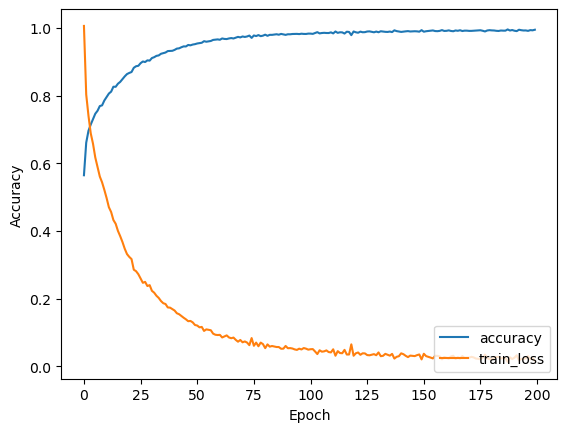

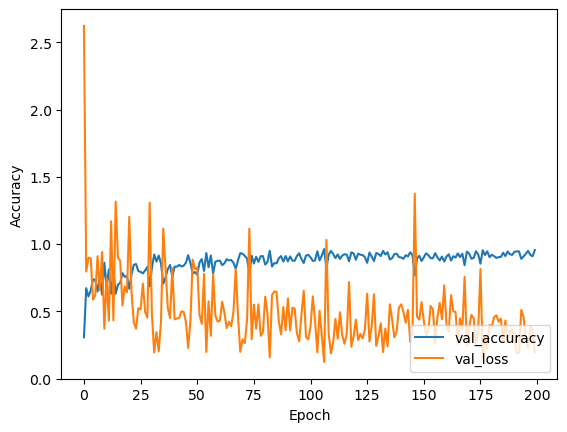

182/182 [==============================] - 1s 3ms/step - loss: 0.1978 - acc: 0.9560
Accuracy on validation dataset = 0.9560420513153076
182/182 [==============================] - 1s 3ms/step - loss: 0.1239 - acc: 0.9629
Accuracy on validation dataset = 0.9629374146461487
seq: 32, unit: 85
start
Epoch 1/200
726/726 [==============================] - 11s 10ms/step - loss: 1.0021 - acc: 0.5639 - val_loss: 1.1039 - val_acc: 0.5525
Epoch 2/200
726/726 [==============================] - 6s 9ms/step - loss: 0.8009 - acc: 0.6636 - val_loss: 1.3228 - val_acc: 0.5273
Epoch 3/200
726/726 [==============================] - 6s 9ms/step - loss: 0.7319 - acc: 0.6980 - val_loss: 1.5740 - val_acc: 0.4465
Epoch 4/200
726/726 [==============================] - 6s 9ms/step - loss: 0.6845 - acc: 0.7171 - val_loss: 0.8565 - val_acc: 0.6418
Epoch 5/200
726/726 [==============================] - 6s 9ms/step - loss: 0.6477 - acc: 0.7328 - val_loss: 1.5369 - val_acc: 0.5308
Epoch 6/200
726/726 [================

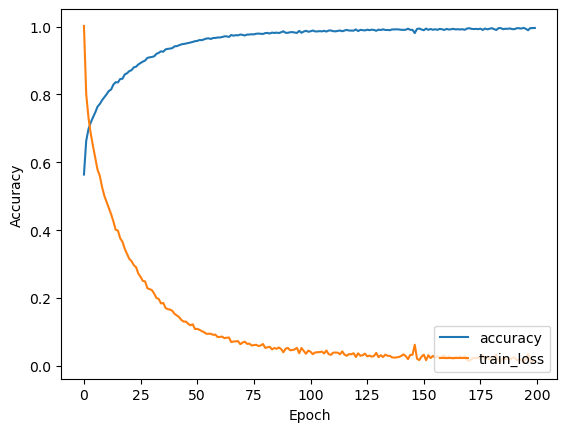

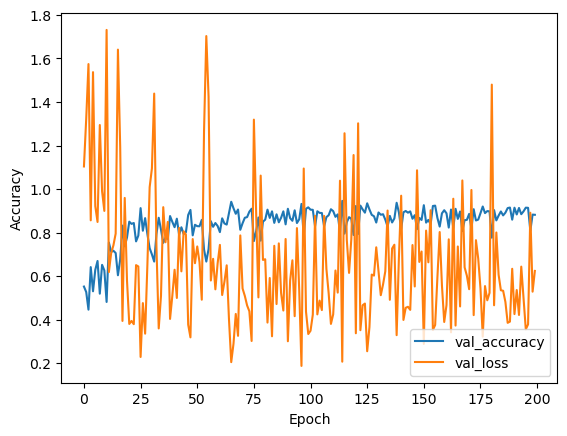

182/182 [==============================] - 1s 3ms/step - loss: 0.6243 - acc: 0.8819
Accuracy on validation dataset = 0.8819169402122498
182/182 [==============================] - 1s 3ms/step - loss: 0.1881 - acc: 0.9319
Accuracy on validation dataset = 0.9319083094596863
seq: 32, unit: 90
start
Epoch 1/200
726/726 [==============================] - 11s 10ms/step - loss: 1.0151 - acc: 0.5654 - val_loss: 0.9738 - val_acc: 0.5682
Epoch 2/200
726/726 [==============================] - 6s 9ms/step - loss: 0.7926 - acc: 0.6695 - val_loss: 0.9417 - val_acc: 0.5892
Epoch 3/200
726/726 [==============================] - 6s 9ms/step - loss: 0.7382 - acc: 0.6959 - val_loss: 0.8997 - val_acc: 0.6373
Epoch 4/200
726/726 [==============================] - 6s 9ms/step - loss: 0.6935 - acc: 0.7135 - val_loss: 0.9662 - val_acc: 0.6371
Epoch 5/200
726/726 [==============================] - 6s 9ms/step - loss: 0.6486 - acc: 0.7338 - val_loss: 1.7210 - val_acc: 0.5099
Epoch 6/200
726/726 [================

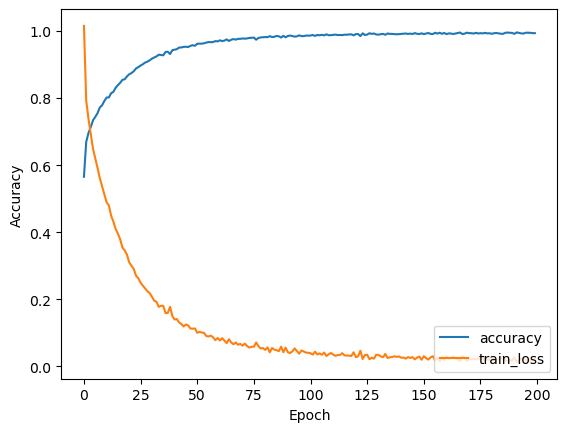

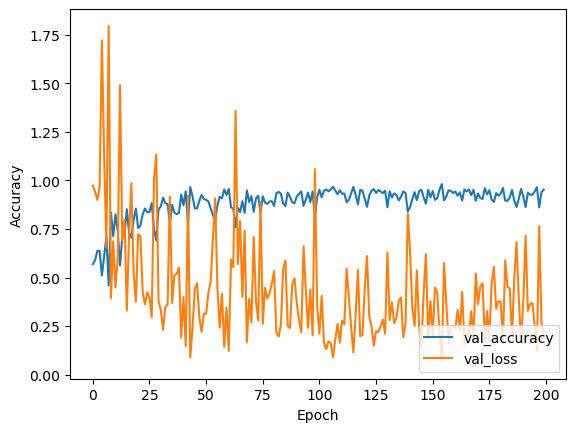

182/182 [==============================] - 1s 3ms/step - loss: 0.2000 - acc: 0.9529
Accuracy on validation dataset = 0.9529391527175903
182/182 [==============================] - 1s 3ms/step - loss: 0.0656 - acc: 0.9812
Accuracy on validation dataset = 0.9812101125717163
seq: 34, unit: 80
start
Epoch 1/200
691/691 [==============================] - 10s 10ms/step - loss: 0.9974 - acc: 0.5662 - val_loss: 2.1014 - val_acc: 0.4431
Epoch 2/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7713 - acc: 0.6777 - val_loss: 1.0260 - val_acc: 0.5920
Epoch 3/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7134 - acc: 0.7039 - val_loss: 0.9024 - val_acc: 0.6376
Epoch 4/200
691/691 [==============================] - 6s 9ms/step - loss: 0.6644 - acc: 0.7267 - val_loss: 1.0399 - val_acc: 0.6125
Epoch 5/200
691/691 [==============================] - 6s 8ms/step - loss: 0.6328 - acc: 0.7378 - val_loss: 1.2671 - val_acc: 0.5027
Epoch 6/200
691/691 [================

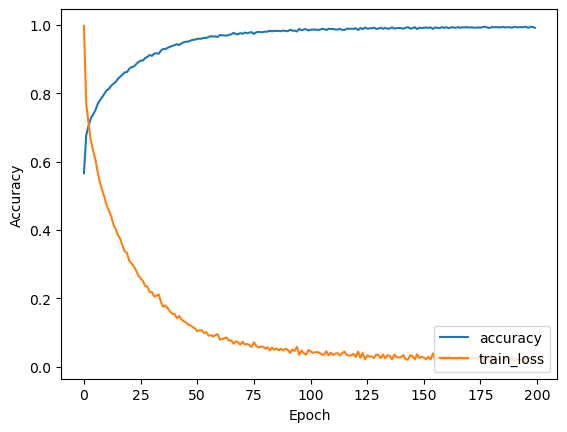

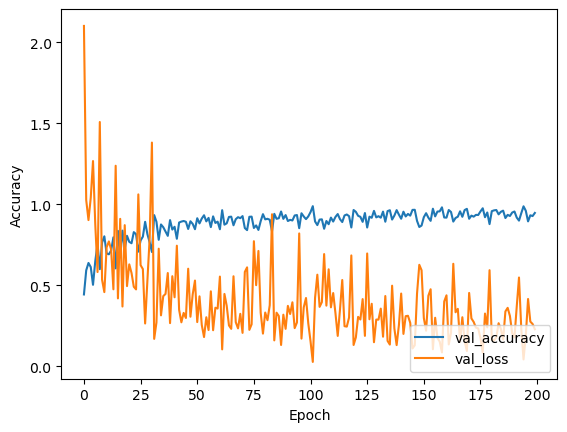

173/173 [==============================] - 1s 4ms/step - loss: 0.2283 - acc: 0.9466
Accuracy on validation dataset = 0.9465773105621338
173/173 [==============================] - 1s 3ms/step - loss: 0.0265 - acc: 0.9884
Accuracy on validation dataset = 0.9884099960327148
seq: 34, unit: 85
start
Epoch 1/200
691/691 [==============================] - 11s 11ms/step - loss: 0.9988 - acc: 0.5675 - val_loss: 3.2355 - val_acc: 0.3962
Epoch 2/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7675 - acc: 0.6820 - val_loss: 1.3245 - val_acc: 0.5284
Epoch 3/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7121 - acc: 0.7104 - val_loss: 0.8289 - val_acc: 0.6183
Epoch 4/200
691/691 [==============================] - 6s 9ms/step - loss: 0.6631 - acc: 0.7303 - val_loss: 0.7468 - val_acc: 0.6947
Epoch 5/200
691/691 [==============================] - 6s 9ms/step - loss: 0.6214 - acc: 0.7458 - val_loss: 0.7157 - val_acc: 0.7106
Epoch 6/200
691/691 [================

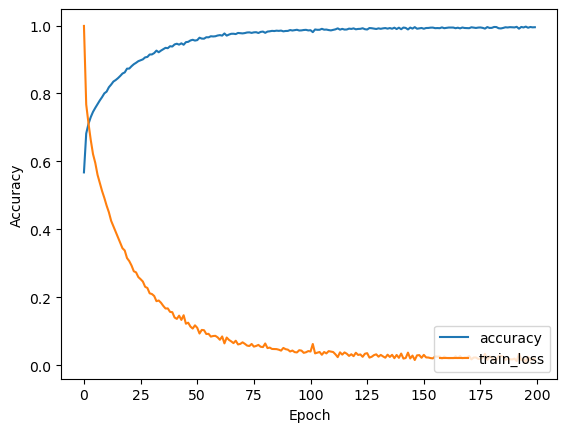

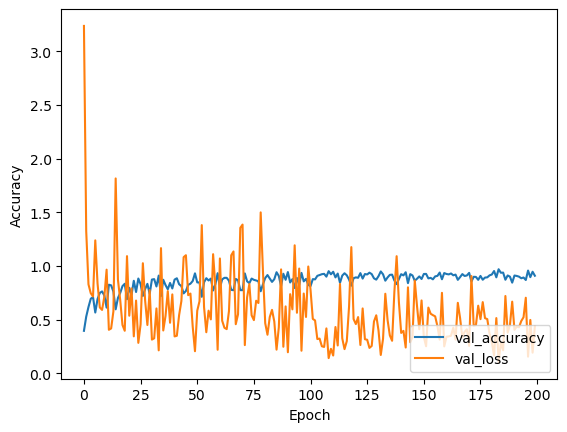

173/173 [==============================] - 1s 3ms/step - loss: 0.4373 - acc: 0.9093
Accuracy on validation dataset = 0.9092720150947571
173/173 [==============================] - 1s 3ms/step - loss: 0.1067 - acc: 0.9698
Accuracy on validation dataset = 0.9697573184967041
seq: 34, unit: 90
start
Epoch 1/200
691/691 [==============================] - 11s 10ms/step - loss: 0.9929 - acc: 0.5753 - val_loss: 2.3613 - val_acc: 0.3968
Epoch 2/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7604 - acc: 0.6797 - val_loss: 1.2084 - val_acc: 0.5449
Epoch 3/200
691/691 [==============================] - 6s 9ms/step - loss: 0.7002 - acc: 0.7111 - val_loss: 1.5415 - val_acc: 0.4734
Epoch 4/200
691/691 [==============================] - 6s 9ms/step - loss: 0.6542 - acc: 0.7303 - val_loss: 1.4948 - val_acc: 0.4806
Epoch 5/200
691/691 [==============================] - 6s 9ms/step - loss: 0.6115 - acc: 0.7510 - val_loss: 1.1548 - val_acc: 0.5900
Epoch 6/200
691/691 [================

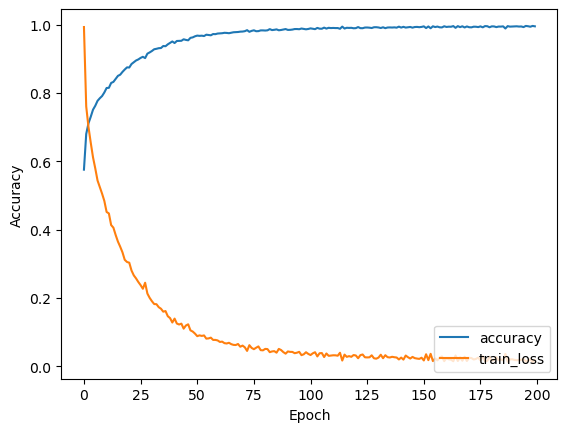

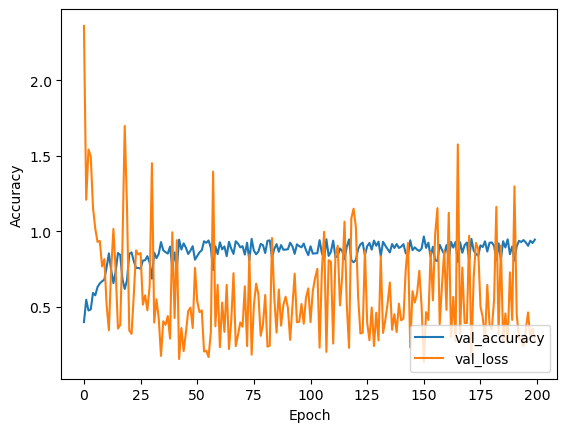

173/173 [==============================] - 1s 3ms/step - loss: 0.2713 - acc: 0.9439
Accuracy on validation dataset = 0.9438609480857849
173/173 [==============================] - 1s 3ms/step - loss: 0.1324 - acc: 0.9647
Accuracy on validation dataset = 0.9646866917610168
seq: 36, unit: 80
start
Epoch 1/200
656/656 [==============================] - 10s 10ms/step - loss: 1.0222 - acc: 0.5546 - val_loss: 0.8445 - val_acc: 0.6116
Epoch 2/200
656/656 [==============================] - 6s 9ms/step - loss: 0.7551 - acc: 0.6874 - val_loss: 2.6605 - val_acc: 0.4098
Epoch 3/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6902 - acc: 0.7147 - val_loss: 0.7705 - val_acc: 0.6719
Epoch 4/200
656/656 [==============================] - 6s 8ms/step - loss: 0.6507 - acc: 0.7321 - val_loss: 0.7875 - val_acc: 0.6881
Epoch 5/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6120 - acc: 0.7524 - val_loss: 0.6474 - val_acc: 0.7348
Epoch 6/200
656/656 [================

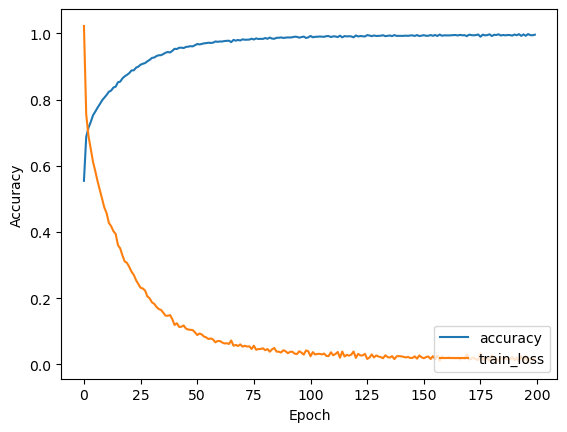

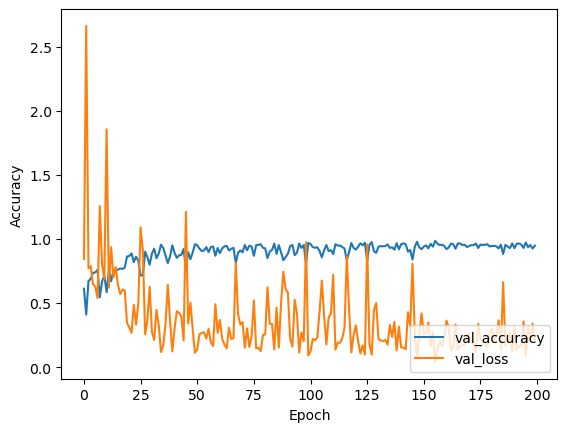

164/164 [==============================] - 1s 3ms/step - loss: 0.2033 - acc: 0.9479
Accuracy on validation dataset = 0.9479206204414368
164/164 [==============================] - 1s 3ms/step - loss: 0.0407 - acc: 0.9849
Accuracy on validation dataset = 0.9849294424057007
seq: 36, unit: 85
start
Epoch 1/200
656/656 [==============================] - 10s 10ms/step - loss: 0.9905 - acc: 0.5748 - val_loss: 1.5451 - val_acc: 0.4641
Epoch 2/200
656/656 [==============================] - 6s 9ms/step - loss: 0.7571 - acc: 0.6907 - val_loss: 0.8665 - val_acc: 0.6414
Epoch 3/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6799 - acc: 0.7222 - val_loss: 0.9600 - val_acc: 0.6124
Epoch 4/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6431 - acc: 0.7367 - val_loss: 0.8821 - val_acc: 0.6578
Epoch 5/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6042 - acc: 0.7540 - val_loss: 1.2512 - val_acc: 0.5044
Epoch 6/200
656/656 [================

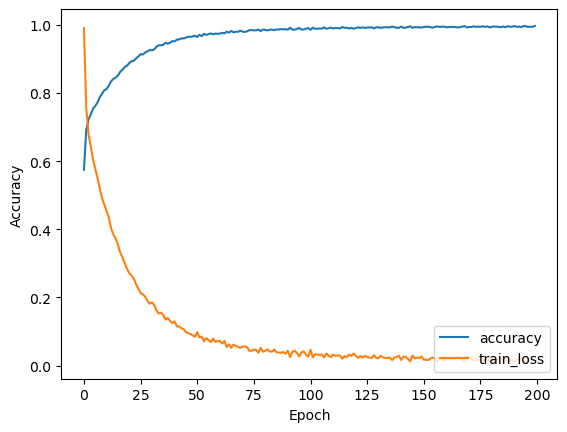

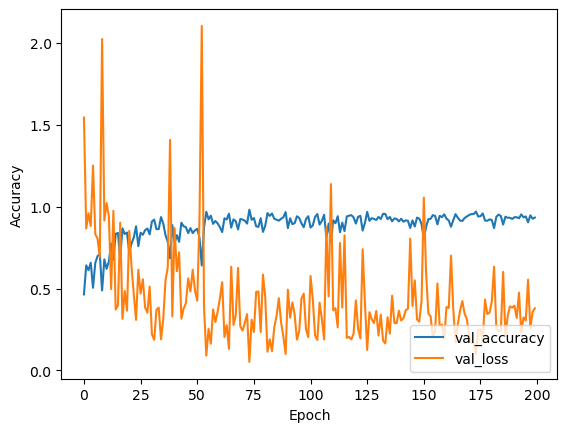

164/164 [==============================] - 1s 3ms/step - loss: 0.3792 - acc: 0.9336
Accuracy on validation dataset = 0.933613121509552
164/164 [==============================] - 1s 3ms/step - loss: 0.0513 - acc: 0.9817
Accuracy on validation dataset = 0.9816863536834717
seq: 36, unit: 90
start
Epoch 1/200
656/656 [==============================] - 10s 10ms/step - loss: 0.9827 - acc: 0.5748 - val_loss: 1.5663 - val_acc: 0.5195
Epoch 2/200
656/656 [==============================] - 6s 9ms/step - loss: 0.7402 - acc: 0.6939 - val_loss: 0.8411 - val_acc: 0.6286
Epoch 3/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6758 - acc: 0.7219 - val_loss: 1.3501 - val_acc: 0.5454
Epoch 4/200
656/656 [==============================] - 6s 9ms/step - loss: 0.6303 - acc: 0.7408 - val_loss: 0.7005 - val_acc: 0.7459
Epoch 5/200
656/656 [==============================] - 6s 9ms/step - loss: 0.5859 - acc: 0.7606 - val_loss: 1.0066 - val_acc: 0.6145
Epoch 6/200
656/656 [=================

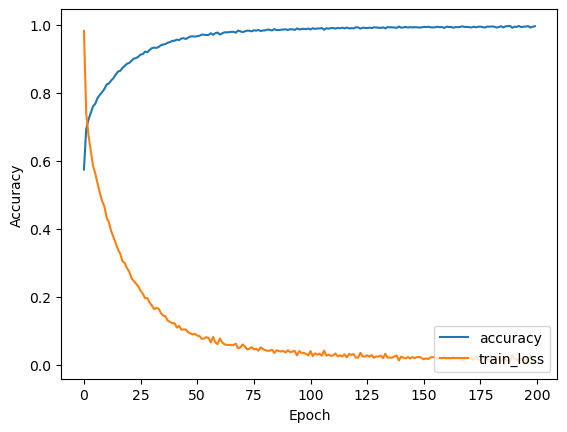

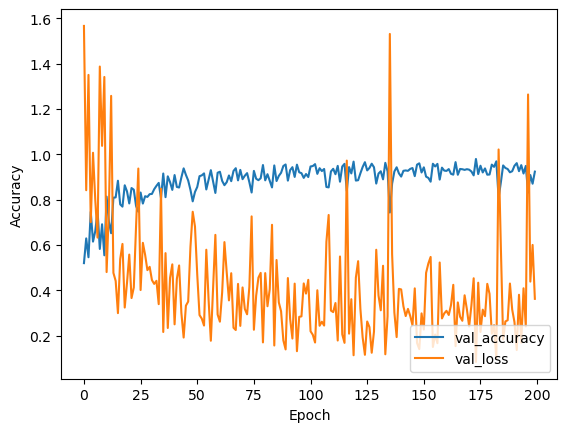

164/164 [==============================] - 1s 3ms/step - loss: 0.3618 - acc: 0.9233
Accuracy on validation dataset = 0.923311710357666
164/164 [==============================] - 1s 3ms/step - loss: 0.0835 - acc: 0.9790
Accuracy on validation dataset = 0.9790156483650208
seq: 38, unit: 80
start
Epoch 1/200
621/621 [==============================] - 10s 11ms/step - loss: 1.0010 - acc: 0.5711 - val_loss: 0.9165 - val_acc: 0.5816
Epoch 2/200
621/621 [==============================] - 5s 9ms/step - loss: 0.7360 - acc: 0.6982 - val_loss: 0.9230 - val_acc: 0.6140
Epoch 3/200
621/621 [==============================] - 5s 9ms/step - loss: 0.6596 - acc: 0.7286 - val_loss: 1.3777 - val_acc: 0.5461
Epoch 4/200
621/621 [==============================] - 5s 9ms/step - loss: 0.6351 - acc: 0.7396 - val_loss: 0.5961 - val_acc: 0.7736
Epoch 5/200
621/621 [==============================] - 5s 9ms/step - loss: 0.5917 - acc: 0.7541 - val_loss: 0.8361 - val_acc: 0.6944
Epoch 6/200
621/621 [=================

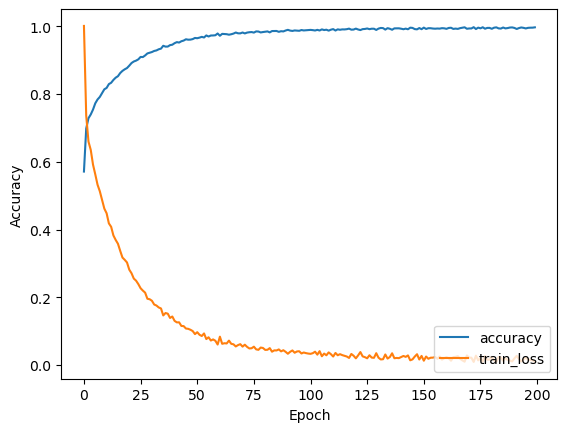

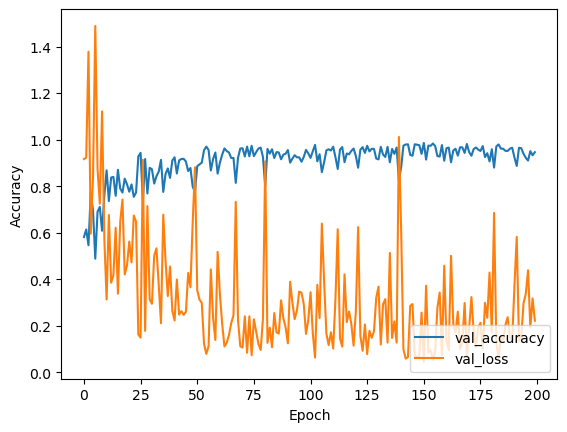

156/156 [==============================] - 1s 3ms/step - loss: 0.2221 - acc: 0.9462
Accuracy on validation dataset = 0.9462127089500427
156/156 [==============================] - 1s 3ms/step - loss: 0.0450 - acc: 0.9861
Accuracy on validation dataset = 0.986099898815155
seq: 38, unit: 85
start
Epoch 1/200
621/621 [==============================] - 11s 12ms/step - loss: 0.9989 - acc: 0.5739 - val_loss: 1.2131 - val_acc: 0.5473
Epoch 2/200
621/621 [==============================] - 6s 9ms/step - loss: 0.7356 - acc: 0.7010 - val_loss: 1.2636 - val_acc: 0.4911
Epoch 3/200
621/621 [==============================] - 6s 9ms/step - loss: 0.6682 - acc: 0.7252 - val_loss: 1.0118 - val_acc: 0.5870
Epoch 4/200
621/621 [==============================] - 6s 9ms/step - loss: 0.6207 - acc: 0.7478 - val_loss: 0.6446 - val_acc: 0.7260
Epoch 5/200
621/621 [==============================] - 5s 9ms/step - loss: 0.5917 - acc: 0.7553 - val_loss: 1.0173 - val_acc: 0.6029
Epoch 6/200
621/621 [=================

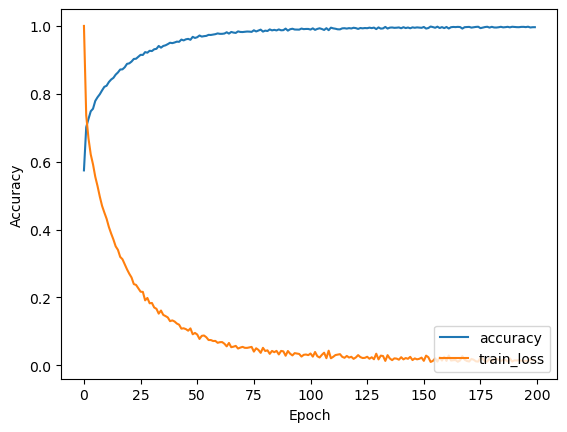

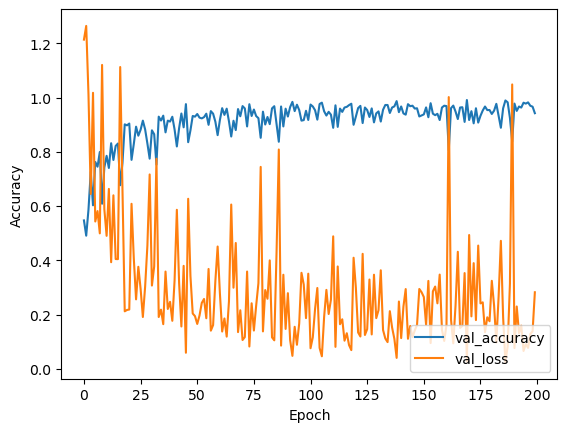

156/156 [==============================] - 1s 3ms/step - loss: 0.2827 - acc: 0.9422
Accuracy on validation dataset = 0.9421837329864502
156/156 [==============================] - 1s 3ms/step - loss: 0.0262 - acc: 0.9891
Accuracy on validation dataset = 0.989121675491333
seq: 38, unit: 90
start
Epoch 1/200
621/621 [==============================] - 11s 12ms/step - loss: 0.9679 - acc: 0.5919 - val_loss: 1.6841 - val_acc: 0.3062
Epoch 2/200
621/621 [==============================] - 6s 9ms/step - loss: 0.7139 - acc: 0.7077 - val_loss: 0.9843 - val_acc: 0.6180
Epoch 3/200
621/621 [==============================] - 6s 9ms/step - loss: 0.6554 - acc: 0.7311 - val_loss: 0.7873 - val_acc: 0.6676
Epoch 4/200
621/621 [==============================] - 6s 9ms/step - loss: 0.6121 - acc: 0.7525 - val_loss: 0.5152 - val_acc: 0.7712
Epoch 5/200
621/621 [==============================] - 6s 9ms/step - loss: 0.5856 - acc: 0.7610 - val_loss: 0.9659 - val_acc: 0.6017
Epoch 6/200
621/621 [=================

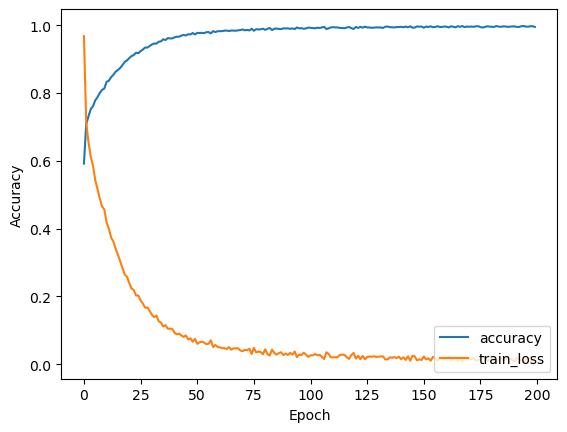

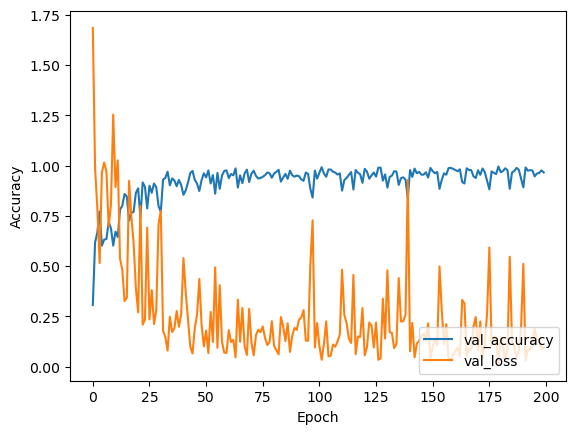

156/156 [==============================] - 1s 3ms/step - loss: 0.0961 - acc: 0.9656
Accuracy on validation dataset = 0.9655519723892212
156/156 [==============================] - 1s 3ms/step - loss: 0.0134 - acc: 0.9954
Accuracy on validation dataset = 0.995366632938385
seq: 40, unit: 80
start
Epoch 1/200
586/586 [==============================] - 10s 11ms/step - loss: 0.9805 - acc: 0.5825 - val_loss: 0.9415 - val_acc: 0.6221
Epoch 2/200
586/586 [==============================] - 5s 9ms/step - loss: 0.7173 - acc: 0.7066 - val_loss: 0.9250 - val_acc: 0.6428
Epoch 3/200
586/586 [==============================] - 5s 9ms/step - loss: 0.6458 - acc: 0.7369 - val_loss: 1.0570 - val_acc: 0.6065
Epoch 4/200
586/586 [==============================] - 5s 9ms/step - loss: 0.6003 - acc: 0.7558 - val_loss: 1.0611 - val_acc: 0.5913
Epoch 5/200
586/586 [==============================] - 5s 9ms/step - loss: 0.5566 - acc: 0.7772 - val_loss: 0.8071 - val_acc: 0.6980
Epoch 6/200
586/586 [=================

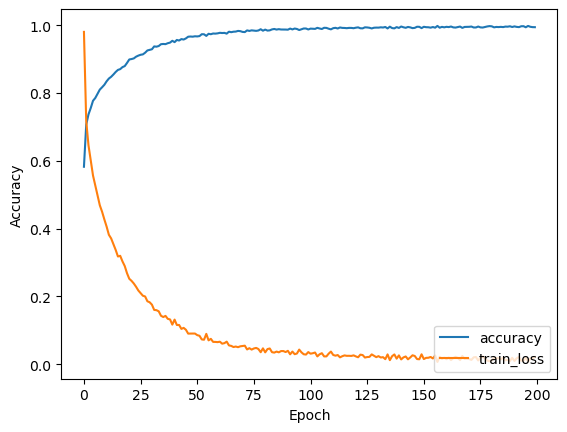

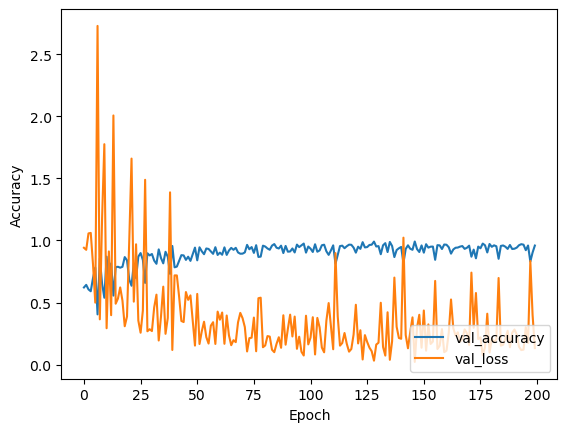

147/147 [==============================] - 1s 3ms/step - loss: 0.1339 - acc: 0.9592
Accuracy on validation dataset = 0.9592403173446655
147/147 [==============================] - 1s 3ms/step - loss: 0.0226 - acc: 0.9919
Accuracy on validation dataset = 0.9918907284736633
seq: 40, unit: 85
start
Epoch 1/200
586/586 [==============================] - 11s 12ms/step - loss: 0.9758 - acc: 0.5860 - val_loss: 1.8173 - val_acc: 0.4324
Epoch 2/200
586/586 [==============================] - 5s 9ms/step - loss: 0.7079 - acc: 0.7118 - val_loss: 2.8329 - val_acc: 0.3357
Epoch 3/200
586/586 [==============================] - 5s 9ms/step - loss: 0.6338 - acc: 0.7439 - val_loss: 0.6361 - val_acc: 0.7486
Epoch 4/200
586/586 [==============================] - 5s 9ms/step - loss: 0.5947 - acc: 0.7559 - val_loss: 1.3531 - val_acc: 0.6033
Epoch 5/200
586/586 [==============================] - 5s 9ms/step - loss: 0.5560 - acc: 0.7731 - val_loss: 0.9450 - val_acc: 0.6428
Epoch 6/200
586/586 [================

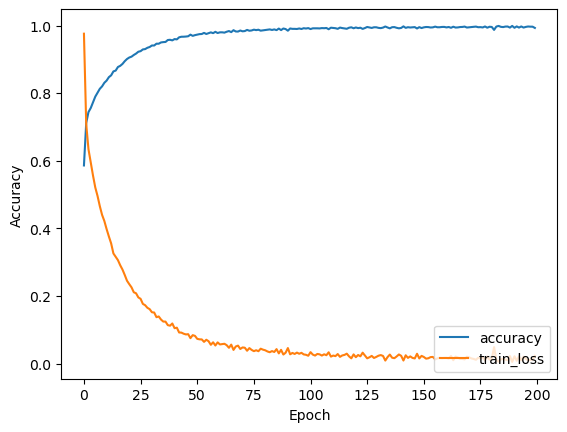

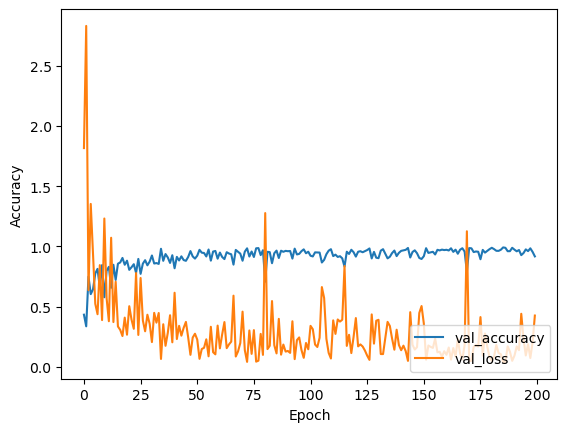

147/147 [==============================] - 1s 3ms/step - loss: 0.4252 - acc: 0.9170
Accuracy on validation dataset = 0.9169867634773254
147/147 [==============================] - 1s 3ms/step - loss: 0.0397 - acc: 0.9915
Accuracy on validation dataset = 0.9914639592170715
seq: 40, unit: 90
start
Epoch 1/200
586/586 [==============================] - 10s 11ms/step - loss: 0.9771 - acc: 0.5852 - val_loss: 2.2539 - val_acc: 0.3871
Epoch 2/200
586/586 [==============================] - 5s 9ms/step - loss: 0.7164 - acc: 0.7051 - val_loss: 1.5603 - val_acc: 0.5087
Epoch 3/200
586/586 [==============================] - 5s 9ms/step - loss: 0.6400 - acc: 0.7395 - val_loss: 1.2046 - val_acc: 0.5602
Epoch 4/200
586/586 [==============================] - 5s 9ms/step - loss: 0.6062 - acc: 0.7566 - val_loss: 1.6304 - val_acc: 0.5871
Epoch 5/200
586/586 [==============================] - 5s 9ms/step - loss: 0.5639 - acc: 0.7688 - val_loss: 0.7320 - val_acc: 0.6893
Epoch 6/200
586/586 [================

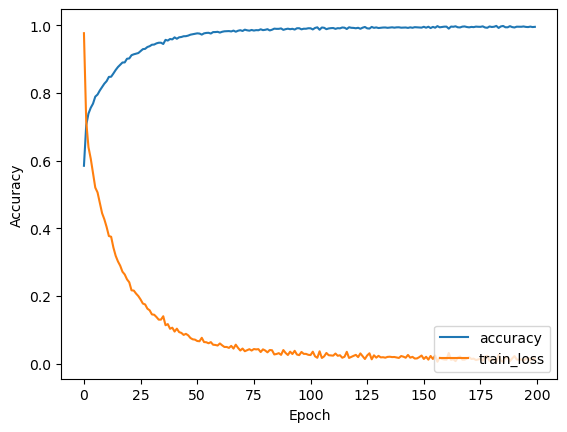

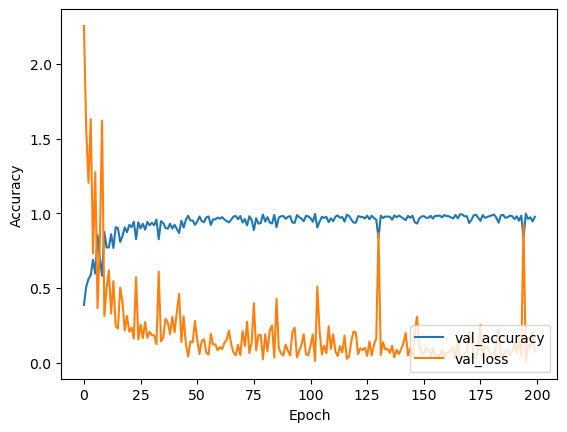

147/147 [==============================] - 1s 3ms/step - loss: 0.0754 - acc: 0.9770
Accuracy on validation dataset = 0.9769526124000549
147/147 [==============================] - 1s 3ms/step - loss: 0.0056 - acc: 0.9979
Accuracy on validation dataset = 0.9978659749031067


In [6]:
sequence_lengths = [30, 32, 34, 36, 38, 40]
units = [80, 85, 90]
num_classes = 4

for seq in sequence_lengths:
    for unit in units:
        print(f'seq: {seq}, unit: {unit}')
        print('start')
        X, y = create_datasets(seq)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

        # One-hot Encoding
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_valid = le.fit_transform(y_valid)
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_valid = to_categorical(y_valid, num_classes=num_classes)

        model = Sequential([
            Input(shape=(seq, 26)),
            Masking(mask_value=0.0),
            GRU(unit, dropout=0.1),
            BatchNormalization(),
            Dropout(0.5),
            Dense(unit, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        
        checkpoint = ModelCheckpoint(f'../models/model/gru{unit}_seq{seq}.h5', verbose=0, save_best_only=True, period=1)
        # scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

        batch_size = 32
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=200,
            batch_size=batch_size,
            callbacks=[checkpoint]
        )

        # train
        plt.plot(history.history['acc'], label='accuracy')
        plt.plot(history.history['loss'], label = 'train_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        
        # valid
        plt.plot(history.history['val_acc'], label='val_accuracy')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        model.load_weights(f'../models/model/gru{unit}_seq{seq}.h5')

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

In [23]:
def create_datasets(sequence_length):
    X = []
    y = []

    motions = ['backhand', 'forehand', 'servicesmash', 'volley']
    for motion in motions:
        base_path = f'../keypoints/datasets/{motion}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거
            
            if motion == 'backhand':
                df['class'] = 0

            elif motion == 'forehand':
                df['class'] = 1

            elif motion == 'servicesmash':
                df['class'] = 2
                
            elif motion == 'volley':
                df['class'] = 3
            
            # Sequence Dataset으로 변경
            if len(df) >= sequence_length:
                if len(df) <= 17+sequence_length+1:
                    data = df.iloc[len(df)-sequence_length : len(df)+1, :].reset_index(drop=True)
                else:
                    data = df.iloc[17 : 17+sequence_length, :].reset_index(drop=True)
            else:
                continue
            
            features = data.loc[:, data.columns != 'class']

            X.append(features.to_numpy())
            y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y


seq: 30, unit: 24
start
Epoch 1/200
18/18 [==============================] - 5s 80ms/step - loss: 1.7012 - acc: 0.2411 - val_loss: 1.4086 - val_acc: 0.2000
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 1.4605 - acc: 0.2768 - val_loss: 1.4213 - val_acc: 0.2357
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 1.3759 - acc: 0.3071 - val_loss: 1.4282 - val_acc: 0.2357
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 1.2617 - acc: 0.3929 - val_loss: 1.4255 - val_acc: 0.2357
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 1.2468 - acc: 0.4125 - val_loss: 1.4140 - val_acc: 0.2357
Epoch 6/200
18/18 [==============================] - 0s 10ms/step - loss: 1.2224 - acc: 0.4196 - val_loss: 1.3924 - val_acc: 0.2429
Epoch 7/200
18/18 [==============================] - 0s 11ms/step - loss: 1.1877 - acc: 0.4196 - val_loss: 1.3883 - val_acc: 0.2571
Epoch 8/200
18/18 [==============================] - 0s 

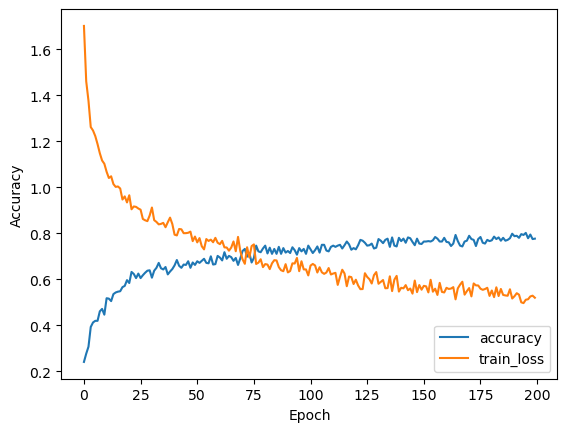

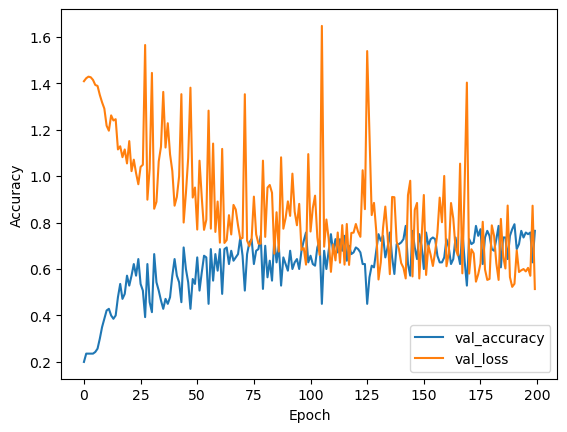

5/5 [==============================] - 0s 4ms/step - loss: 0.5137 - acc: 0.7643
Accuracy on validation dataset = 0.7642857432365417
5/5 [==============================] - 0s 4ms/step - loss: 0.5137 - acc: 0.7643
Accuracy on validation dataset = 0.7642857432365417


In [25]:
sequence_lengths = [30]
units = [24]
num_classes = 4

for seq in sequence_lengths:
    for unit in units:
        print(f'seq: {seq}, unit: {unit}')
        print('start')
        X, y = create_datasets(seq)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

        # One-hot Encoding
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_valid = le.fit_transform(y_valid)
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_valid = to_categorical(y_valid, num_classes=num_classes)

        model = Sequential([
            Input(shape=(seq, 26)),
            Masking(mask_value=0.0),
            GRU(unit, dropout=0.1),
            BatchNormalization(),
            Dropout(0.3),
            Dense(unit, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        
        checkpoint = ModelCheckpoint(f'../models/model/gru{unit}_seq{seq}.h5', verbose=0, save_best_only=True, period=1)
        # scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

        batch_size = 32
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=200,
            batch_size=batch_size,
            callbacks=[checkpoint]
        )

        # train
        plt.plot(history.history['acc'], label='accuracy')
        plt.plot(history.history['loss'], label = 'train_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        
        # valid
        plt.plot(history.history['val_acc'], label='val_accuracy')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        model.load_weights(f'../models/model/gru{unit}_seq{seq}.h5')

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

## 2nd Method

In [17]:
sequence_lengths = [25, 27, 29, 30, 31]
sequence_lengths = [30]
units = [3]
num_classes = 4

for seq in sequence_lengths:
    for unit in units:
        print(f'seq: {seq}, unit: {unit}')
        print('start')
        X_train, y_train, X_valid, y_valid = create_datasets(seq)

        # One-hot Encoding
        le = preprocessing.LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_valid = le.fit_transform(y_valid)
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_valid = to_categorical(y_valid, num_classes=num_classes)

        model = Sequential([
            Input(shape=(seq, 26)),
            Masking(mask_value=0.0),
            LSTM(80, return_sequences=True, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(80, return_sequences=True, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(80, return_sequences=True, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(80, return_sequences=False, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(48, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        
        checkpoint = ModelCheckpoint(f'../models/model/lstm{unit}_seq{seq}.h5', verbose=0, save_best_only=True, period=1)
        # scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

        batch_size = 32
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=200,
            batch_size=batch_size,
            callbacks=[checkpoint]
        )

        # train
        plt.plot(history.history['acc'], label='train_accuracy')
        plt.plot(history.history['val_acc'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        
        # valid
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        plt.show()

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

        model.load_weights(f'../models/model/lstm{unit}_seq{seq}.h5')

        loss, accuracy = model.evaluate(X_valid, y_valid)
        print(f"Accuracy on validation dataset = {accuracy}")

seq: 30, unit: 3
start
Epoch 1/200
126/126 [==============================] - 62s 443ms/step - loss: 0.6299 - acc: 0.7537 - val_loss: 1.3751 - val_acc: 0.4549
Epoch 2/200
126/126 [==============================] - 55s 435ms/step - loss: 0.3016 - acc: 0.8897 - val_loss: 1.3875 - val_acc: 0.4660
Epoch 3/200
126/126 [==============================] - 53s 422ms/step - loss: 0.2339 - acc: 0.9164 - val_loss: 1.2018 - val_acc: 0.5218
Epoch 4/200
126/126 [==============================] - 53s 421ms/step - loss: 0.1886 - acc: 0.9351 - val_loss: 1.5775 - val_acc: 0.4574
Epoch 5/200
126/126 [==============================] - 54s 428ms/step - loss: 0.1484 - acc: 0.9478 - val_loss: 1.3592 - val_acc: 0.6493
Epoch 6/200
126/126 [==============================] - 56s 442ms/step - loss: 0.1311 - acc: 0.9543 - val_loss: 3.7675 - val_acc: 0.4580
Epoch 7/200
126/126 [==============================] - 57s 452ms/step - loss: 0.1418 - acc: 0.9516 - val_loss: 3.6061 - val_acc: 0.4764
Epoch 8/200
126/126 [====

KeyboardInterrupt: 

In [4]:
model = load_model('../models/gru80_seq36.h5')
model.compile()
model.summary()
plot_model(model, show_shapes=True, to_file='./model.png')

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_20 (Masking)        (None, 36, 26)            0         
                                                                 
 gru_20 (GRU)                (None, 80)                25920     
                                                                 
 batch_normalization_20 (Bat  (None, 80)               320       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 80)                0         
                                                                 
 dense_40 (Dense)            (None, 80)                6480      
                                                                 
 dense_41 (Dense)            (None, 4)                 324       
                                                     